# Credit Card Customer Clusters Using K-Means Clustering

## Objective

- Menganalisis karakteristik dari profil pembelian, transaksi, credit limit, dan frekuensi pembelian dari masing-masing client
- Pengelompokan client guna memfokuskan promosi kepada nasabah yang tepat
- Menganalisis promo apa yang diberikan ke tiap cluster clients

## Data

Data yang digunakan adalah data dari client suatu bank yang di-query menggunakan syntax di bawah ini.

select * from `ftds-hacktiv8-project.phase1_ftds_018_rmt.credit-card-information`
where MOD(CUST_ID,2)=0

## Import Libraries

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from matplotlib import image as mpimg
import outlier_func
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
%matplotlib inline

## Data Load

In [2]:
# Read the data
df_ori=pd.read_csv('dataset.csv')
df=df_ori.copy()

# Viewing the head of the data
df.head(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0      788    16.581535           0.125000      200.0               0.0   
1     1902   943.584041           0.875000      103.0             103.0   
2     2322     1.979916           0.125000       80.0              80.0   
3     3426   461.455720           1.000000      585.0             585.0   
4     3976  1053.594730           1.000000     1450.0            1450.0   
5     4266  2237.238086           1.000000      120.0             120.0   
6     4360  2730.843802           1.000000     2900.0            2900.0   
7     4680   424.994385           0.375000     1200.0            1200.0   
8     5884    18.885677           0.375000       57.0              57.0   
9       24     0.004816           0.545455       51.7               0.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   200.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   
5                     0.0           0.0                0.125   
6                     0.0           0.0                0.125   
7                     0.0           0.0                0.125   
8                     0.0           0.0                0.125   
9                    51.7           0.0                0.250   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000                             0.125   
1                       0.125                             0.000   
2                       0.125                             0.000   
3                       0.125                             0.000   
4                       0.125                             0.000   
5                       0.125                             0.000   
6                       0.125                             0.000   
7                       0.125                             0.000   
8                       0.125                             0.000   
9                       0.000                             0.250   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              2        1200.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   
5                     0.0                 0              1        2500.0   
6                     0.0                 0              1        2900.0   
7                     0.0                 0              1        1200.0   
8                     0.0                 0              1        1500.0   
9                     0.0                 0              3        3000.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0    0.000000               NaN               0.0       8  
1  215.325023        410.484825               0.0       8  
2    0.000000               NaN               0.0       8  
3  258.032630        151.696433               0.0       8  
4  397.090516        227.143184               0.0       8  
5  343.102984        712.986387               0.0       8  
6    0.000000               NaN               0.0       8  
7   57.266292         56.720210               0.0       8  
8    0.000000               NaN               0.0       8  
9   33.249088          0.059481               0.0      12

In [3]:
# Viewing the tail of the data
df.tail(10)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
4465     1588   538.768762           0.909091     226.95            129.58   
4466     6900  7468.012010           1.000000    1569.41            796.07   
4467     2528   427.642111           0.888889       0.00              0.00   
4468     1226   706.327578           0.888889     169.54            169.54   
4469     2152  1420.727073           1.000000       0.00              0.00   
4470     4630  1079.008102           1.000000       0.00              0.00   
4471     8614   809.582978           0.909091       0.00              0.00   
4472     4296  3386.490883           1.000000     560.98            427.22   
4473     4476  4840.545574           1.000000    1595.93           1595.93   
4474     3564  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
4465                   97.37    452.009130             0.545455   
4466                  773.34   4500.288676             0.545455   
4467                    0.00   2563.705644             0.000000   
4468                    0.00   1406.735573             0.333333   
4469                    0.00    311.804499             0.000000   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
4465                    0.090909                          0.454545   
4466                    0.454545                          0.363636   
4467                    0.000000                          0.000000   
4468                    0.333333                          0.000000   
4469                    0.000000                          0.000000   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
4465                0.272727                 8              9        1200.0   
4466                0.272727                 7             10        8700.0   
4467                0.888889                62              0        1200.0   
4468                0.888889                14              3        2500.0   
4469                0.900000                 9              0        1500.0   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
4465   946.649324        211.220001          0.000000      11  
4466  2162.943350       4628.802111          0.000000      11  
4467  2853.967334        146.976542          0.500000       9  
4468   302.976780        142.597254          0.000000       9  
4469   506.765033        449.179818          0.000000      10  
4470  1379.635287        271.364415          0.090909      11  
4471  4372.148648        241.645387          0.090909      11  
4472  1039.000037        886.050237          0.000000      11  
4473   905.844846       2376.919568          0.090909      11  
4474  3056.424974        910.707525          0.090909      11

In [4]:
# Viewing the data type info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

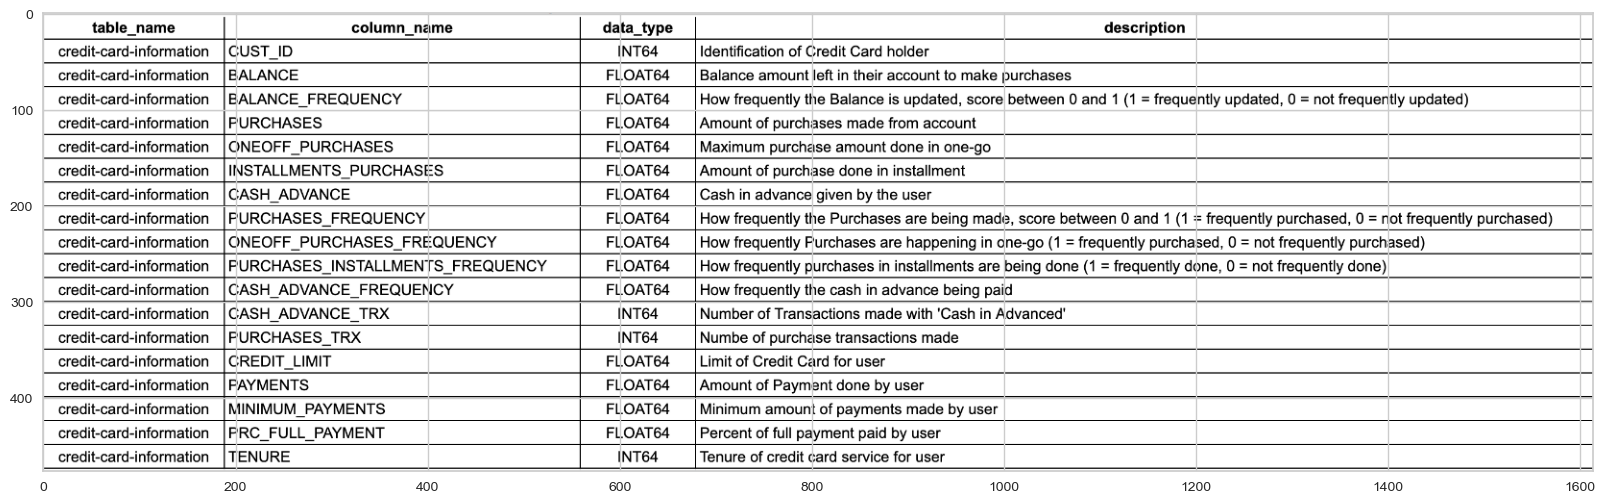

In [5]:
# Viewing the metadata we get from bigquery-public-data
plt.figure(figsize=(20,15))
image1 = mpimg.imread("gc4/img.png")
plt.imshow(image1)

- BALANCE = Credit card limit - outstanding (berapa banyak limit credit card yang dipakai)
- BALANCE_FREQUENCY = 1 atau 0, kalau 0 berarti kesalahan bank blm update status (tidak terlalu berguna di pengelompokkan customer)
- PURCHASES = seberapa sering melakukan pembelian, tanpa mempedulikan jumlah uang yg dipakai (untuk customer yang sering menggunakan kartu kredit, bisa jadi bisa menentukan customer tinggal atau pekerjaan dimana misal tempat makan yg bisa menggunakan credit card atau pekerjaan yg membutuhkan credit card)
- ONEOFF_PURCHASES = 1 transaksi yang nilainya paling maksimum
- INSTALLMENTS_PURCHASES = mencicil 1 transaksi yang biasanya jumlahnya besar dan dicicil selama berapa bulan tanpa bunga, tp dengan 1 kali fee saja selama banyak bulan cicilan (biasanya dipakai untuk membeli capital aset seperti HP, laptop, dsb, dan biasanya untuk subscription seperti netflix spotify dsb)
- CASH_ADVANCE = pembayaran ke credit card meskipun outstanding 0
- PURCHASES_FREQUENCY = persentase jumlah purchases dalam suatu waktu tertentu di 1 tempat
- ONEOFF_PURCHASES_FREQUENCY = frekuensi client menggunakan cc dalam satu waktu di banyak tempat
- PURCHASES_INSTALLMENTS_FREQUENCY = frekuensi dari semua transaksi seberapa banyak yg dijadikan installment
- CASH_ADVANCE_FREQUENCY = seberapa sering melakukan cash in advance dalan persen
- CASH_ADVANCE_TRX = seberapa sering melakukan cash in advance
- PURCHASES_TRX = purchases_frequency dalam angka bukan persen
- CREDIT_LIMIT = limit dari credit card client
- PAYMENTS = pembayaran yang dilakukan client
- MINIMUM_PAYMENTS = 10% dari outstanding
- PRC_FULL_PAYMENT = dalam suatu waktu tertentu, berapa kali bayar langsung full payment sampai jatuh tempo`
- TENURE = jatuh tempo pembayaran

## Exploratory Data Analysis

In [6]:
# Deskripsi singkat dari data client
df.describe()

CUST_ID       BALANCE  BALANCE_FREQUENCY     PURCHASES  \
count  4475.000000   4475.000000        4475.000000   4475.000000   
mean   4476.000000   1565.743939           0.877608   1003.158324   
std    2583.931114   2091.205727           0.235604   2210.812899   
min       2.000000      0.000000           0.000000      0.000000   
25%    2239.000000    132.536353           0.888889     40.065000   
50%    4476.000000    874.905296           1.000000    362.480000   
75%    6713.000000   2058.519163           1.000000   1122.640000   
max    8950.000000  19043.138560           1.000000  49039.570000   

       ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  \
count       4475.000000             4475.000000   4475.000000   
mean         588.504849              415.025075    973.453671   
std         1666.500287              927.360842   2133.464502   
min            0.000000                0.000000      0.000000   
25%            0.000000                0.000000      0.000000   
50%           29.990000               89.450000      0.000000   
75%          580.320000              484.255000   1098.569962   
max        40761.250000            22500.000000  29282.109150   

       PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
count          4475.000000                 4475.000000   
mean              0.490122                    0.202614   
std               0.399874                    0.298502   
min               0.000000                    0.000000   
25%               0.083333                    0.000000   
50%               0.500000                    0.083333   
75%               0.916667                    0.333333   
max               1.000000                    1.000000   

       PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
count                       4475.000000             4475.000000   
mean                           0.364989                0.134156   
std                            0.397336                0.199221   
min                            0.000000                0.000000   
25%                            0.000000                0.000000   
50%                            0.166667                0.000000   
75%                            0.750000                0.181818   
max                            1.000000                1.166667   

       CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT      PAYMENTS  \
count       4475.000000    4475.000000   4474.000000   4475.000000   
mean           3.196425      14.490503   4494.020175   1726.212274   
std            6.500169      24.156038   3668.535689   2961.258570   
min            0.000000       0.000000    150.000000      0.000000   
25%            0.000000       1.000000   1500.000000    390.206371   
50%            0.000000       7.000000   3000.000000    831.048408   
75%            4.000000      17.000000   6000.000000   1895.959003   
max          110.000000     358.000000  30000.000000  46930.598240   

       MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count       4317.000000       4475.000000  4475.000000  
mean         854.429538          0.157206    11.516425  
std         2306.411178          0.295869     1.347819  
min            0.037744          0.000000     6.000000  
25%          169.814310          0.000000    12.000000  
50%          309.854995          0.000000    12.000000  
75%          830.395060          0.166667    12.000000  
max        61031.618600          1.000000    12.000000

- Lebih dari 50% clients memiliki low balance, dengan total pembelian yang jarang dan sedikit serta jarang sekali melakukan cash in advance
- tidak ada nilai negatif pada data yang dimiliki
- Waktu jatuh tempo pembayaran paling banyak 12 bulan

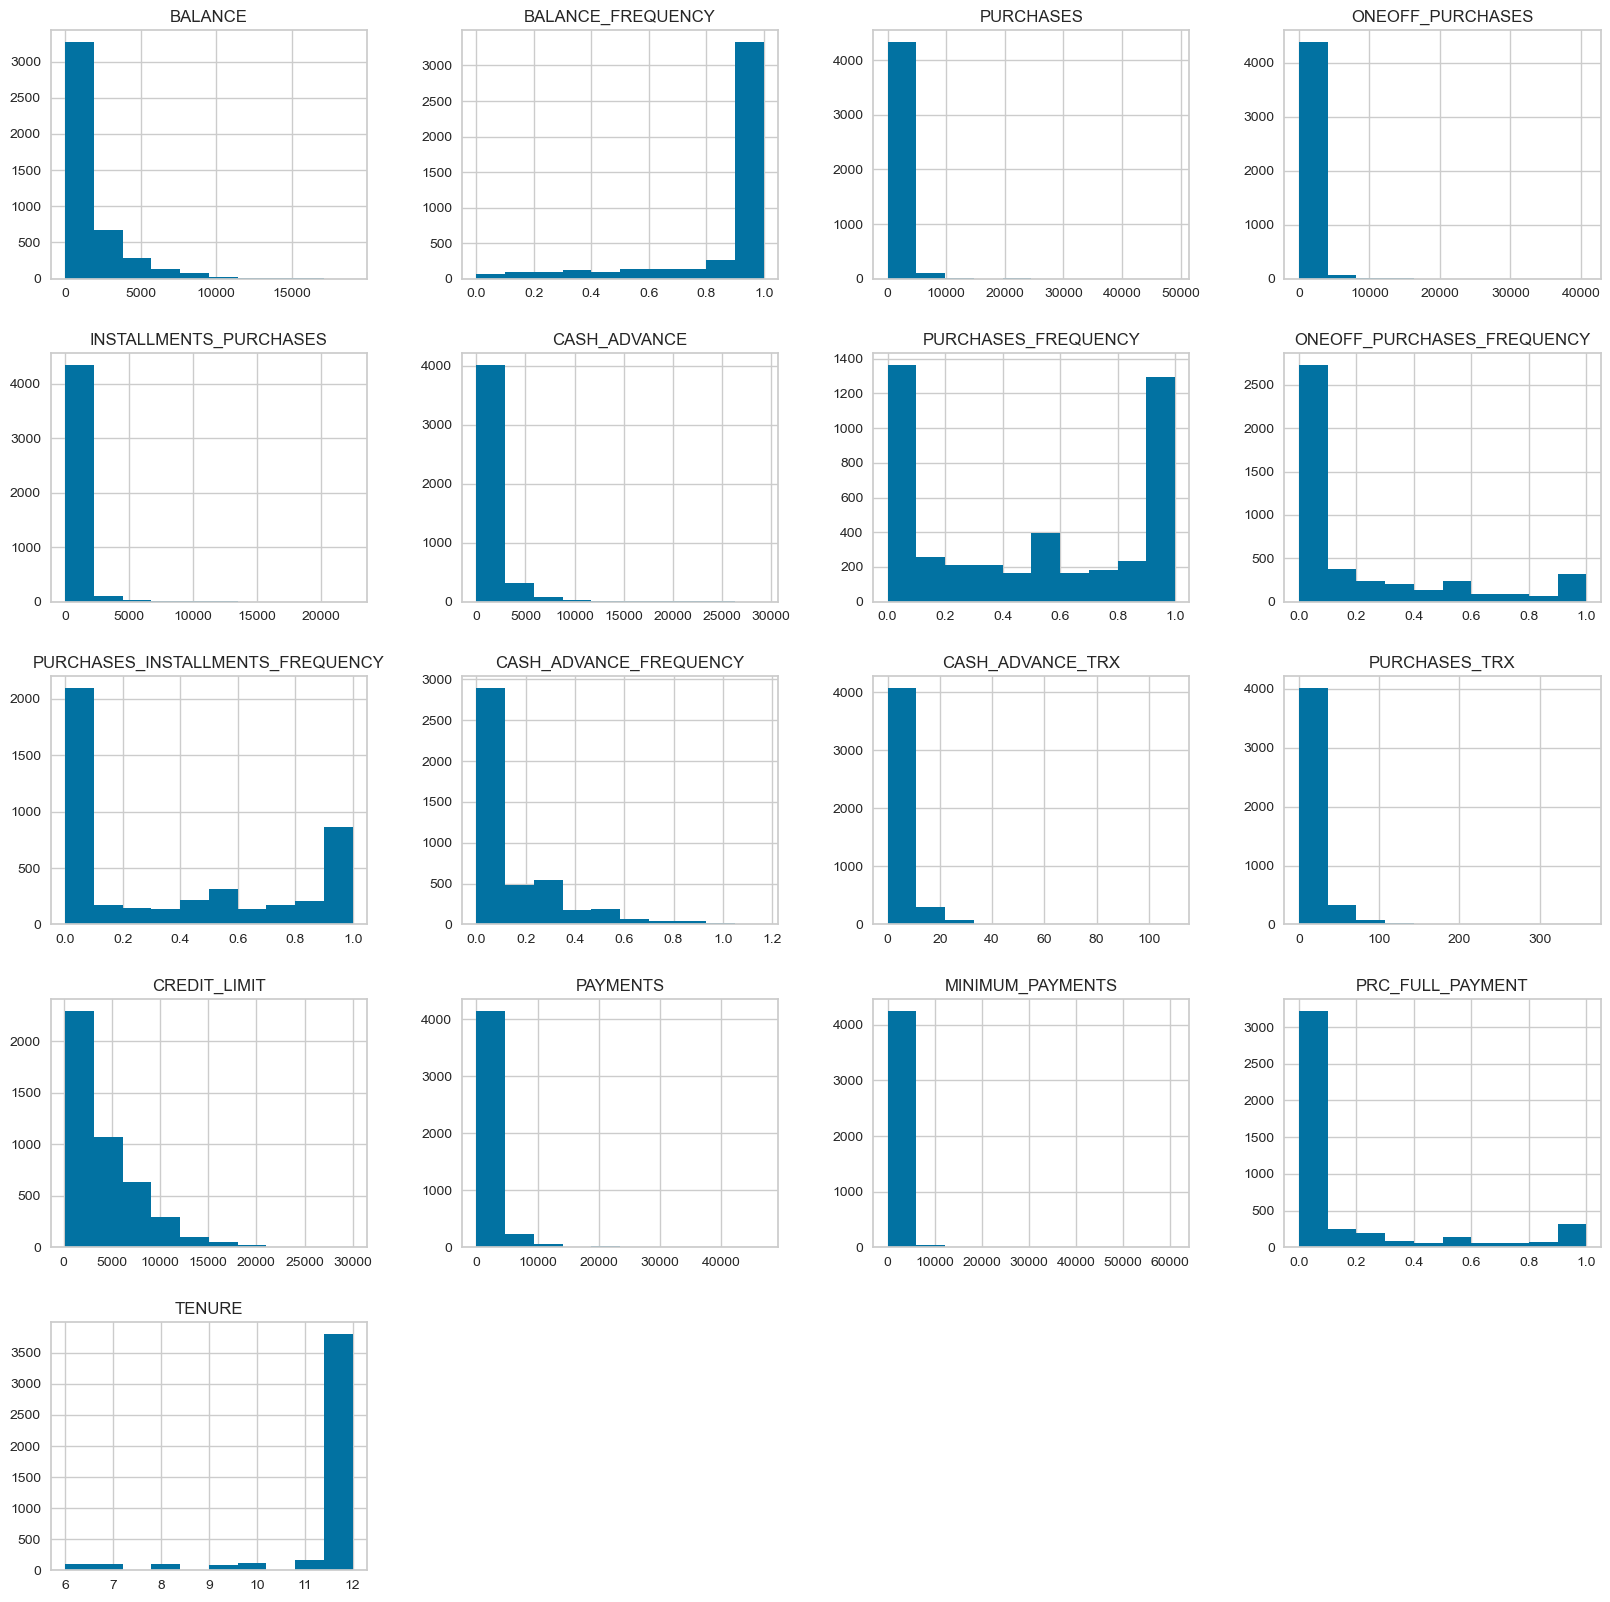

In [7]:
# Melihat persebaran data cash advance frequency
df.iloc[:,1:].hist(figsize = (20,20))
plt.show()

- Semua data terdistribusi miring
- Cash advance frequency memiliki distribusi yang banyak di nilai yang kecil, sebagian besar clients tidak sering melakukan cash in advance
- Sebagian besar clients jarang melakukan pembelian dan pembayaran 
- Sebagian besar clients memiliki limit credit menengah ke bawah
- Lebih banyak clients yang melakukan installment daripada cash in advance
- Menurut histogram di atas, dapat disimpulkan bahwa tidak ada data kategorikal ordinal maupun nominal berdasarkan persebaran nilai dan informasi metadata yang didapat.

<Figure size 2500x1500 with 0 Axes>

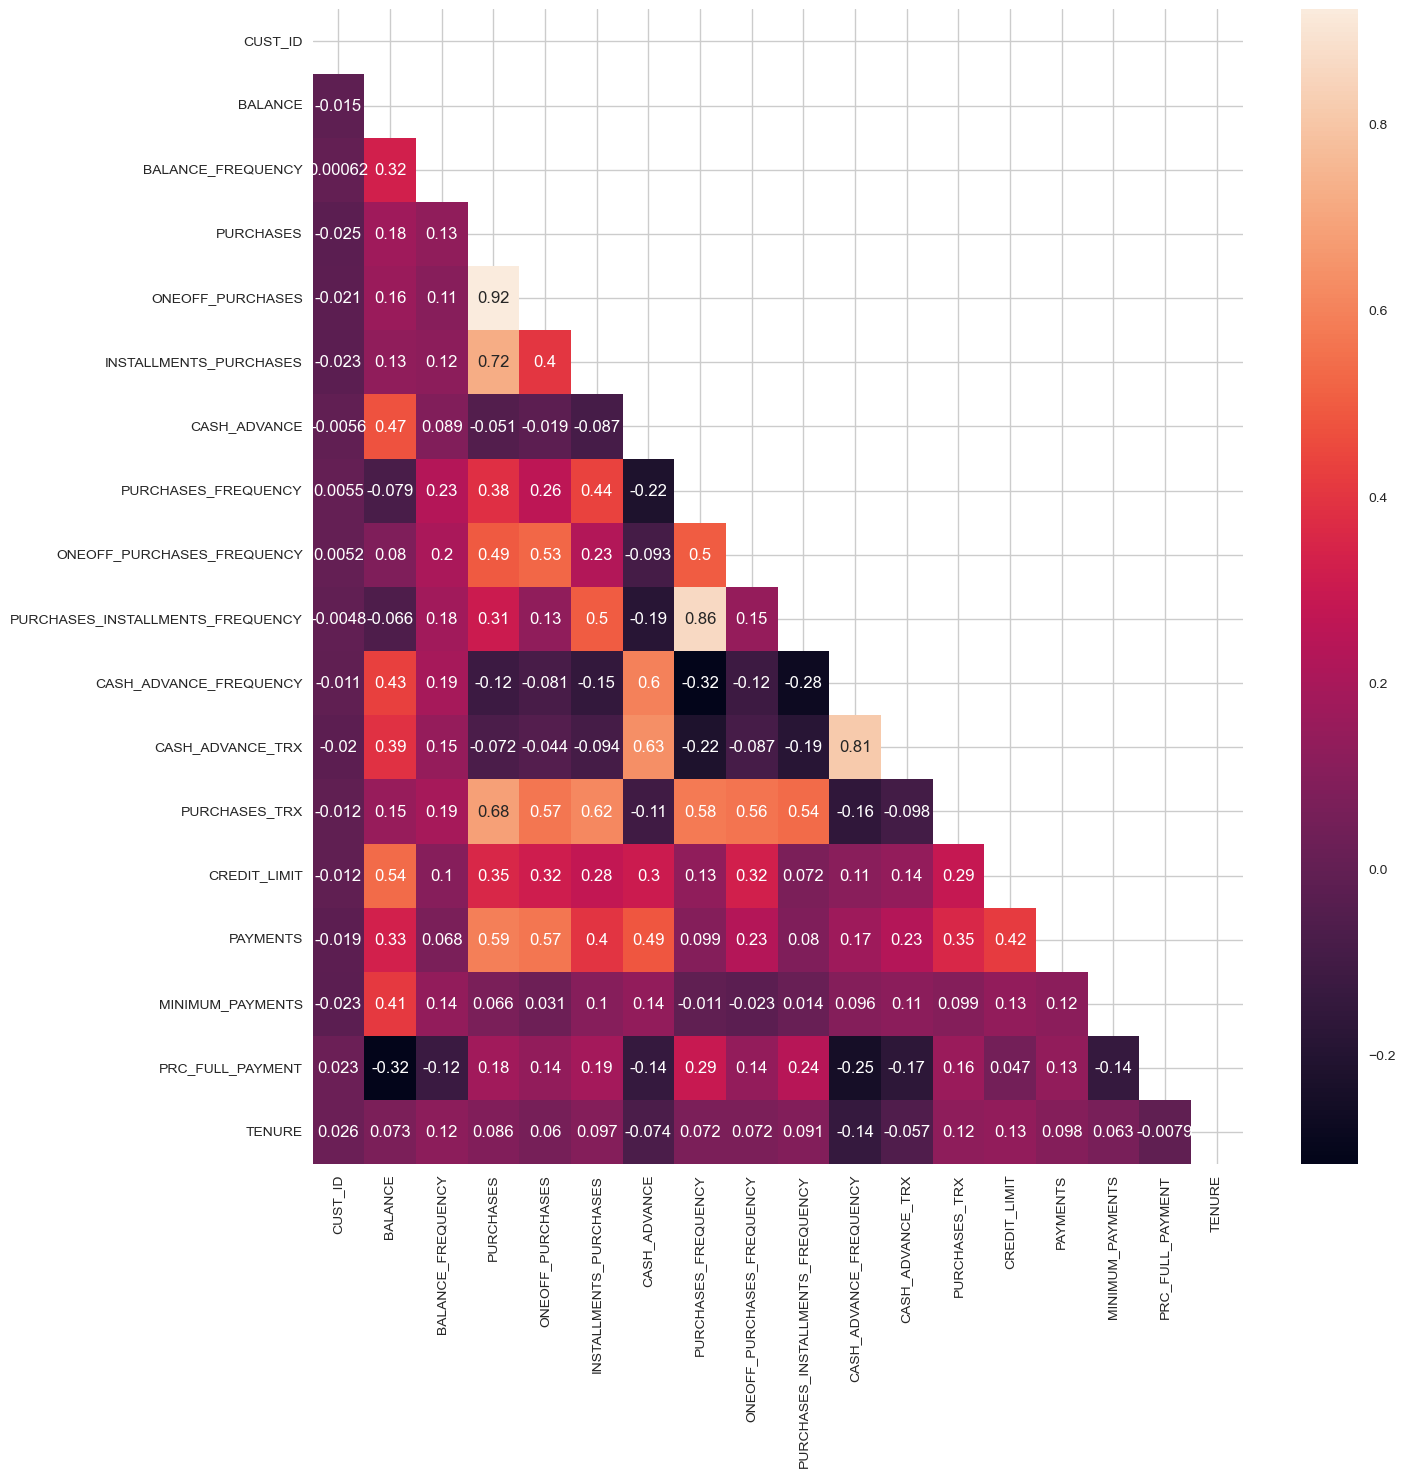

In [9]:
#Check the correlations
plt.figure(figsize=(25,15))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
corr = df.corr()
f, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True, mask=mask)
plt.show()

Beberapa feature seperti purchases installment frequency, cash advance transaction, one off purchases, dsb memiliki hubungan yang tinggi antar fitur. Hal ini akan diatasi saat melakukan dimensi reduksi pada tahapan di bawah.

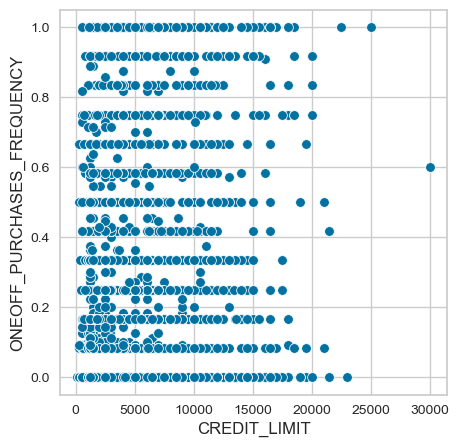

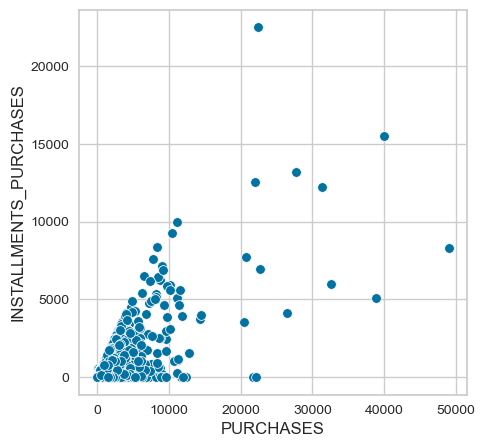

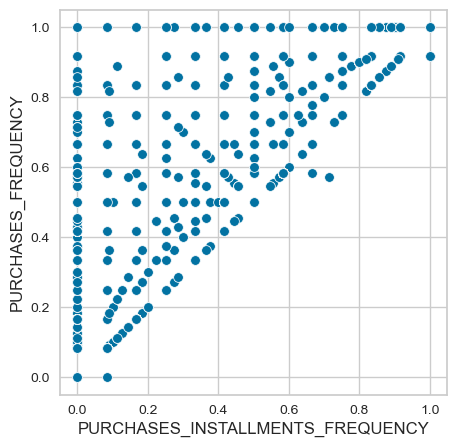

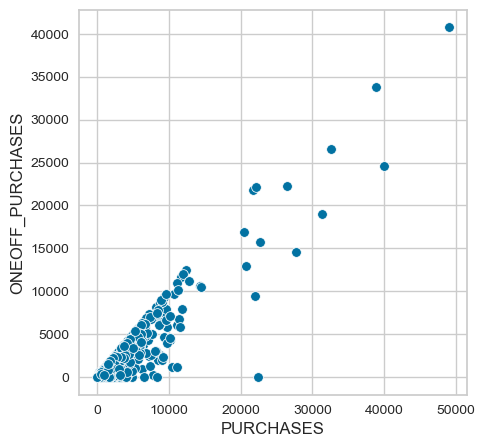

In [10]:
# Melihat korelasi antara semua fitur terhadap death event
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y="ONEOFF_PURCHASES_FREQUENCY")
plt.grid(True)

# Melihat korelasi antara semua fitur terhadap death event
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='PURCHASES', y="INSTALLMENTS_PURCHASES")
plt.grid(True)

# Melihat korelasi antara semua fitur terhadap death event
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='PURCHASES_INSTALLMENTS_FREQUENCY', y="PURCHASES_FREQUENCY")
plt.grid(True)

# Melihat korelasi antara semua fitur terhadap death event
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='PURCHASES', y="ONEOFF_PURCHASES")
plt.grid(True)

- credit limit dan one of purchases dari clients tidak memiliki keterkaitan, artinya clients yang melakukan transaksi yang besar dalam suatu waktu tidak dipengaruhi oleh limit yang dimiliki oleh clients tersebut
- clients yang melakukan pembelian, biasanya melakukan installment purchases juga
- Semakin sering clients melakukan pembelian, biasanya semakin sering juga melakukan pembelian installment
- Sebagian besar clients yang melakukan pembelian dalam jumlah kecil, biasanya one off purchases-nya juga kecil

## Feature Selection

Dalam pemodelan kali ini, akan didrop kolom yang tidak akan mempengaruhi segmentasi clients, yakni balance frequency.

In [11]:
# Drop column balance_frequency yang tidak mempengaruhi segmentasi client
df.drop('BALANCE_FREQUENCY', axis=1, inplace=True)

## Handling Missing Value

In [12]:
# Check missing value
df.isnull().mean()*100

CUST_ID                             0.000000
BALANCE                             0.000000
PURCHASES                           0.000000
ONEOFF_PURCHASES                    0.000000
INSTALLMENTS_PURCHASES              0.000000
CASH_ADVANCE                        0.000000
PURCHASES_FREQUENCY                 0.000000
ONEOFF_PURCHASES_FREQUENCY          0.000000
PURCHASES_INSTALLMENTS_FREQUENCY    0.000000
CASH_ADVANCE_FREQUENCY              0.000000
CASH_ADVANCE_TRX                    0.000000
PURCHASES_TRX                       0.000000
CREDIT_LIMIT                        0.022346
PAYMENTS                            0.000000
MINIMUM_PAYMENTS                    3.530726
PRC_FULL_PAYMENT                    0.000000
TENURE                              0.000000
dtype: float64

Skewness of CREDIT_LIMIT : 1.55


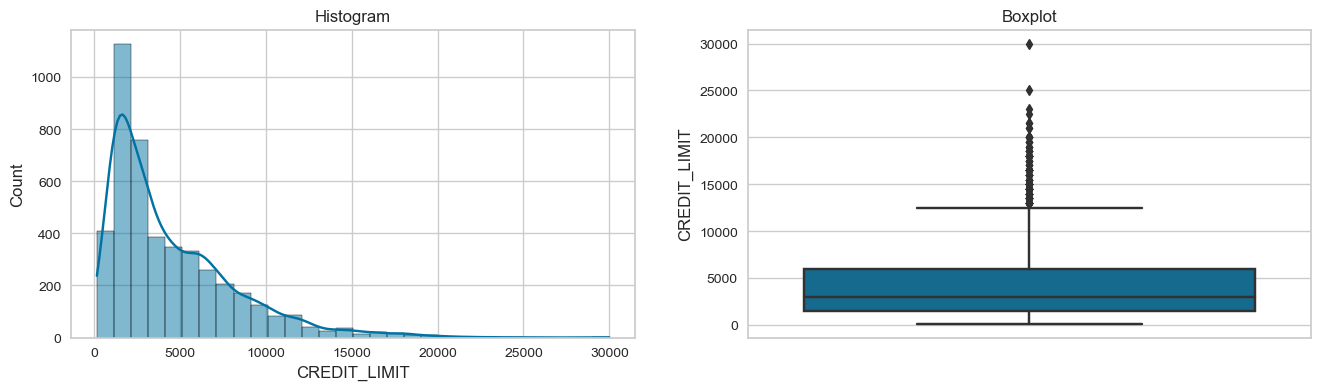

Skewness of MINIMUM_PAYMENTS : 12.36


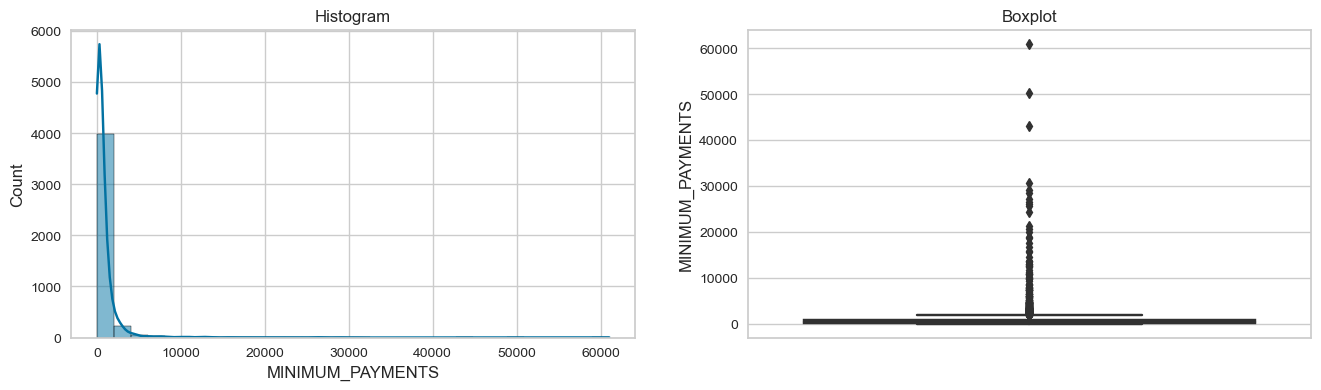

In [13]:
# Melihat kemiringan data sebelum mengimputasi dengan mean atau median
print('Skewness of CREDIT_LIMIT : {:.2f}'.format(df['CREDIT_LIMIT'].skew()))
outlier_func.diagnostic_plots(df, 'CREDIT_LIMIT')

print('Skewness of MINIMUM_PAYMENTS : {:.2f}'.format(df['MINIMUM_PAYMENTS'].skew()))
outlier_func.diagnostic_plots(df, 'MINIMUM_PAYMENTS')

Skewness lebih dari 0.5 sehingga data yang hilang akan di impute dengan median.

In [14]:
# Impute the missing value with median
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(df)
df=pd.DataFrame(imputer.transform(df), columns=df.columns.values)
print ("Percentage of missing value :")
df.isnull().mean()*100

Percentage of missing value :


CUST_ID                             0.0
BALANCE                             0.0
PURCHASES                           0.0
ONEOFF_PURCHASES                    0.0
INSTALLMENTS_PURCHASES              0.0
CASH_ADVANCE                        0.0
PURCHASES_FREQUENCY                 0.0
ONEOFF_PURCHASES_FREQUENCY          0.0
PURCHASES_INSTALLMENTS_FREQUENCY    0.0
CASH_ADVANCE_FREQUENCY              0.0
CASH_ADVANCE_TRX                    0.0
PURCHASES_TRX                       0.0
CREDIT_LIMIT                        0.0
PAYMENTS                            0.0
MINIMUM_PAYMENTS                    0.0
PRC_FULL_PAYMENT                    0.0
TENURE                              0.0
dtype: float64

## Handling Outlier

In [16]:
# Define the numerical
num_cols=df.columns.drop('CUST_ID')

BALANCE
% Upper Outlier for BALANCE : 7.55%
% Lower Outlier for BALANCE : 0.00%
Skewness of BALANCE : 2.46


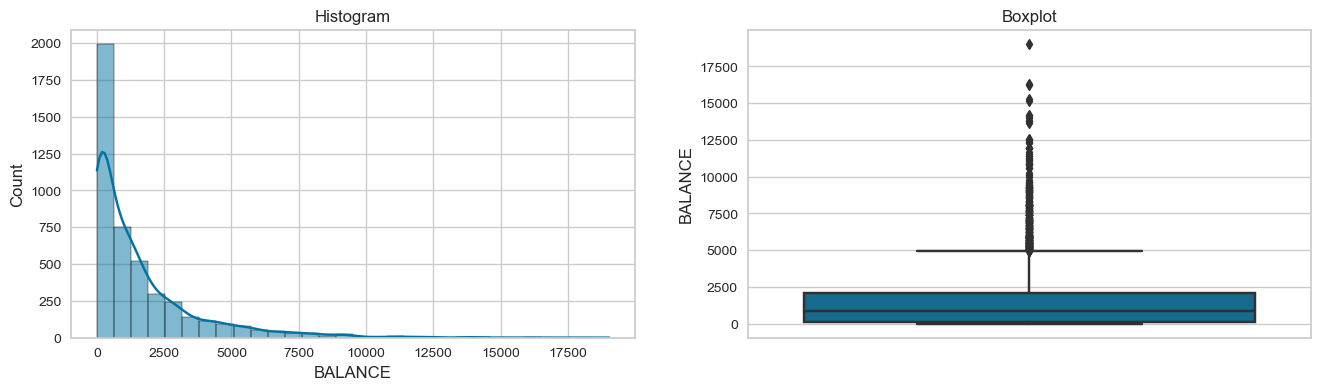

PURCHASES
% Upper Outlier for PURCHASES : 8.58%
% Lower Outlier for PURCHASES : 0.00%
Skewness of PURCHASES : 8.99


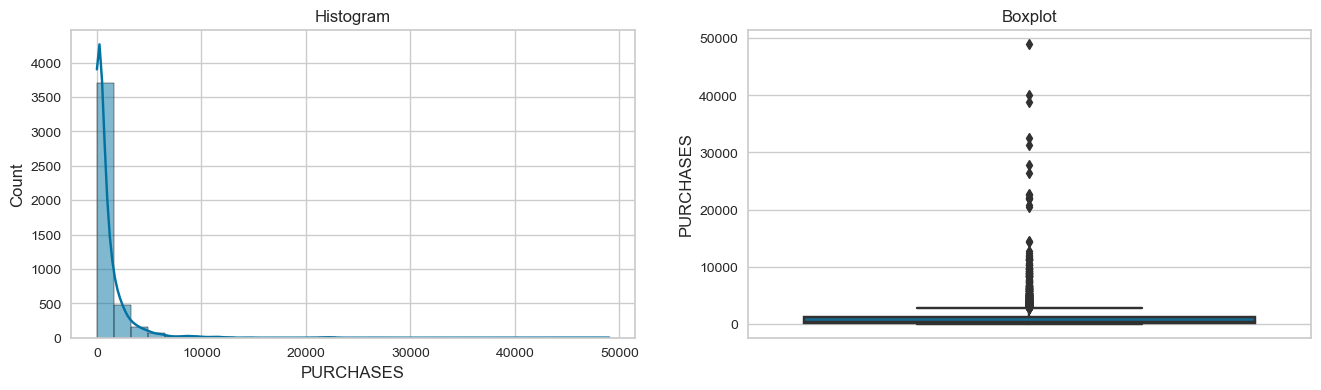

ONEOFF_PURCHASES
% Upper Outlier for ONEOFF_PURCHASES : 10.88%
% Lower Outlier for ONEOFF_PURCHASES : 0.00%
Skewness of ONEOFF_PURCHASES : 10.14


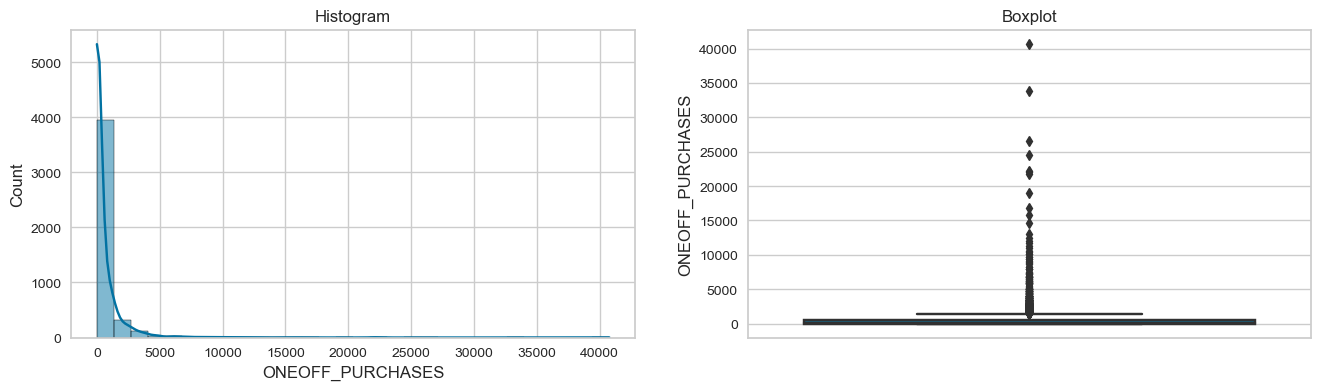

INSTALLMENTS_PURCHASES
% Upper Outlier for INSTALLMENTS_PURCHASES : 9.18%
% Lower Outlier for INSTALLMENTS_PURCHASES : 0.00%
Skewness of INSTALLMENTS_PURCHASES : 8.12


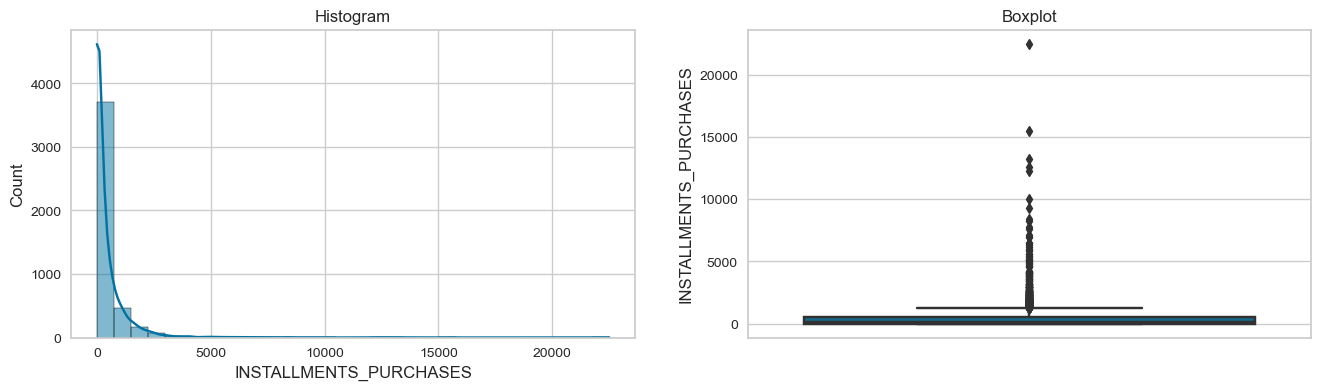

CASH_ADVANCE
% Upper Outlier for CASH_ADVANCE : 11.53%
% Lower Outlier for CASH_ADVANCE : 0.00%
Skewness of CASH_ADVANCE : 4.74


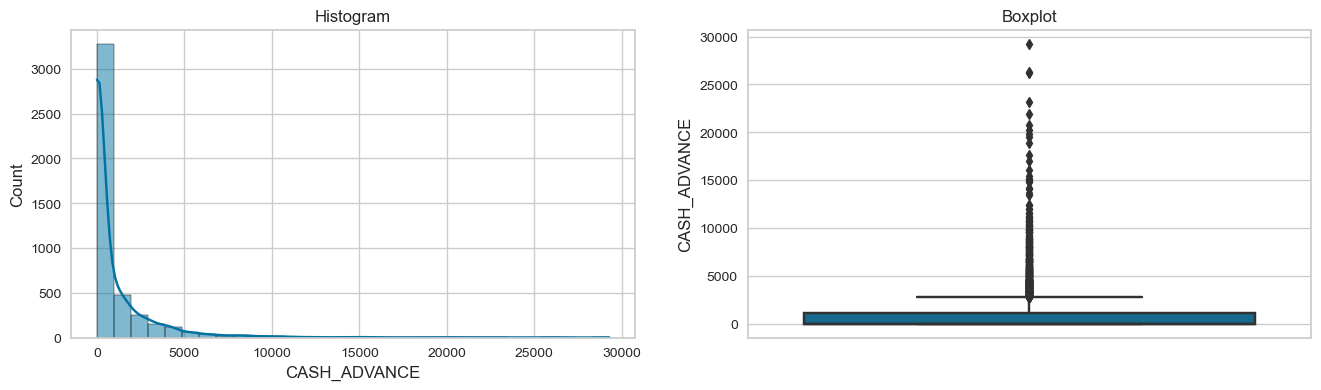

PURCHASES_FREQUENCY
% Upper Outlier for PURCHASES_FREQUENCY : 0.00%
% Lower Outlier for PURCHASES_FREQUENCY : 0.00%
Skewness of PURCHASES_FREQUENCY : 0.06


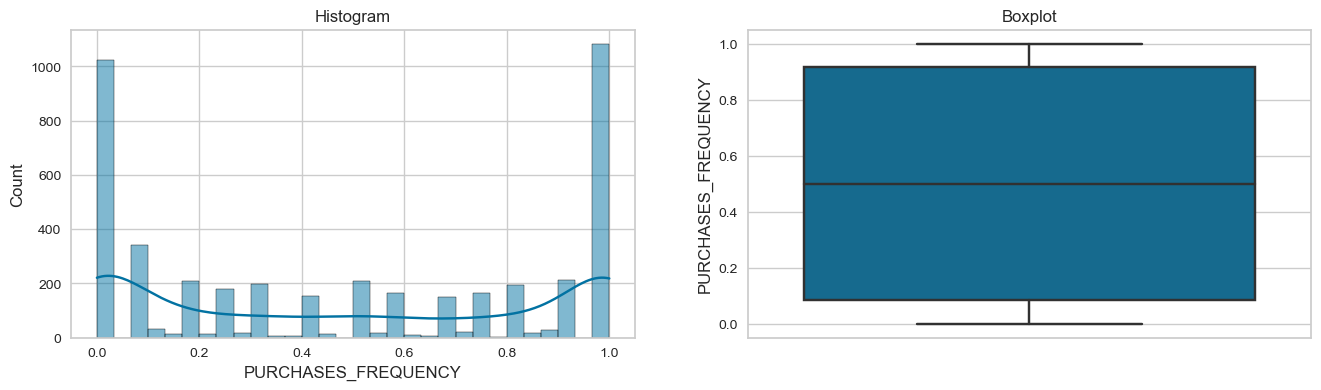

ONEOFF_PURCHASES_FREQUENCY
% Upper Outlier for ONEOFF_PURCHASES_FREQUENCY : 8.47%
% Lower Outlier for ONEOFF_PURCHASES_FREQUENCY : 0.00%
Skewness of ONEOFF_PURCHASES_FREQUENCY : 1.52


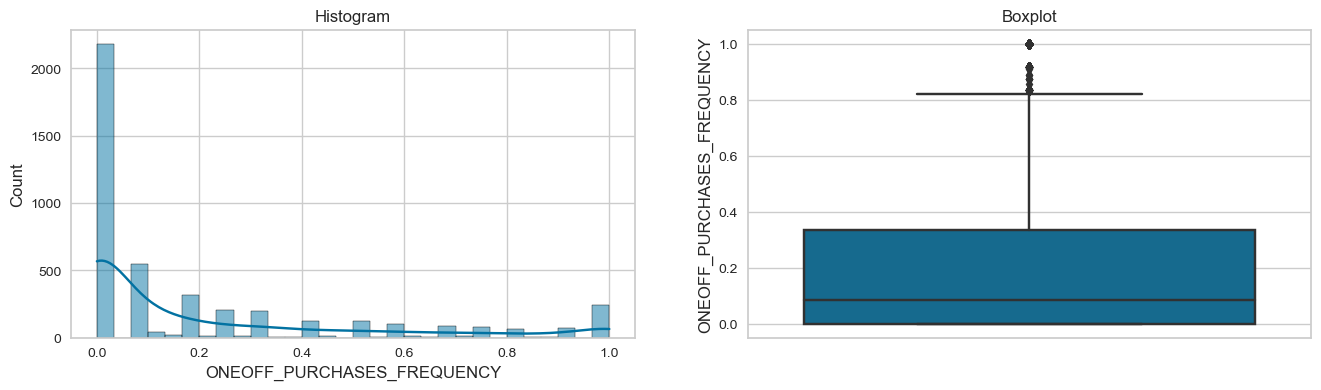

PURCHASES_INSTALLMENTS_FREQUENCY
% Upper Outlier for PURCHASES_INSTALLMENTS_FREQUENCY : 0.00%
% Lower Outlier for PURCHASES_INSTALLMENTS_FREQUENCY : 0.00%
Skewness of PURCHASES_INSTALLMENTS_FREQUENCY : 0.51


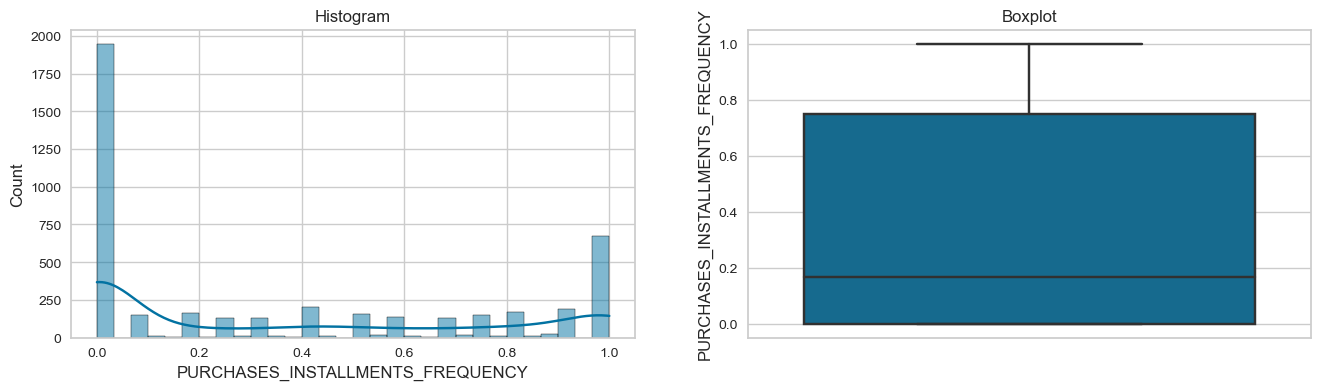

CASH_ADVANCE_FREQUENCY
% Upper Outlier for CASH_ADVANCE_FREQUENCY : 8.31%
% Lower Outlier for CASH_ADVANCE_FREQUENCY : 0.00%
Skewness of CASH_ADVANCE_FREQUENCY : 1.82


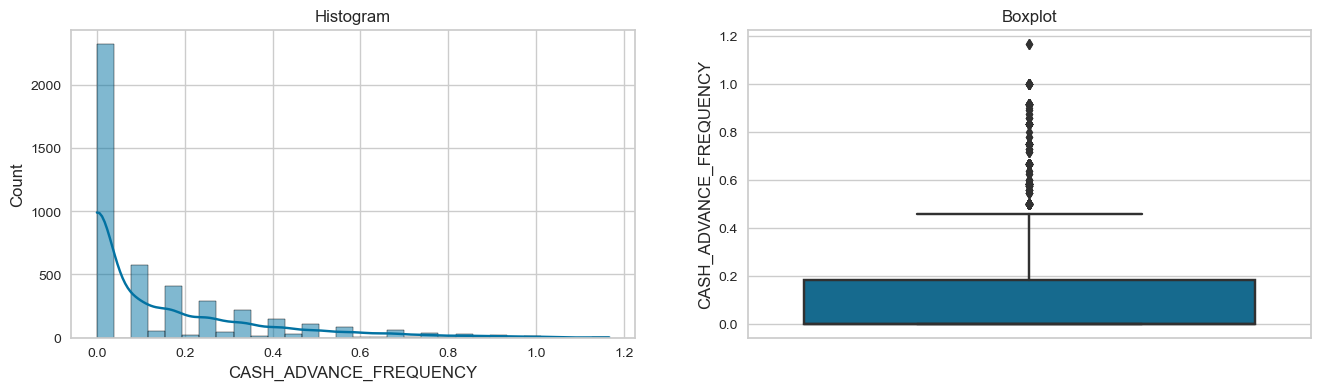

CASH_ADVANCE_TRX
% Upper Outlier for CASH_ADVANCE_TRX : 8.98%
% Lower Outlier for CASH_ADVANCE_TRX : 0.00%
Skewness of CASH_ADVANCE_TRX : 4.75


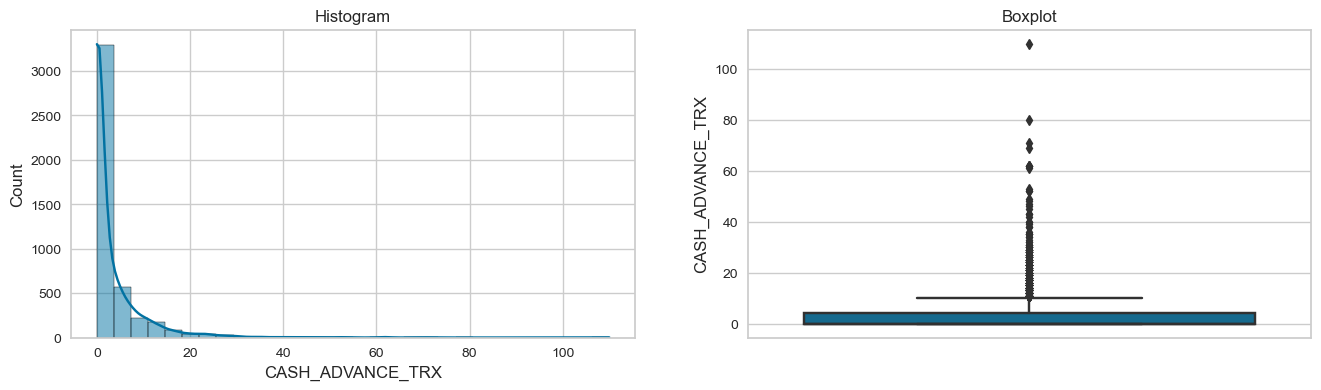

PURCHASES_TRX
% Upper Outlier for PURCHASES_TRX : 8.18%
% Lower Outlier for PURCHASES_TRX : 0.00%
Skewness of PURCHASES_TRX : 4.48


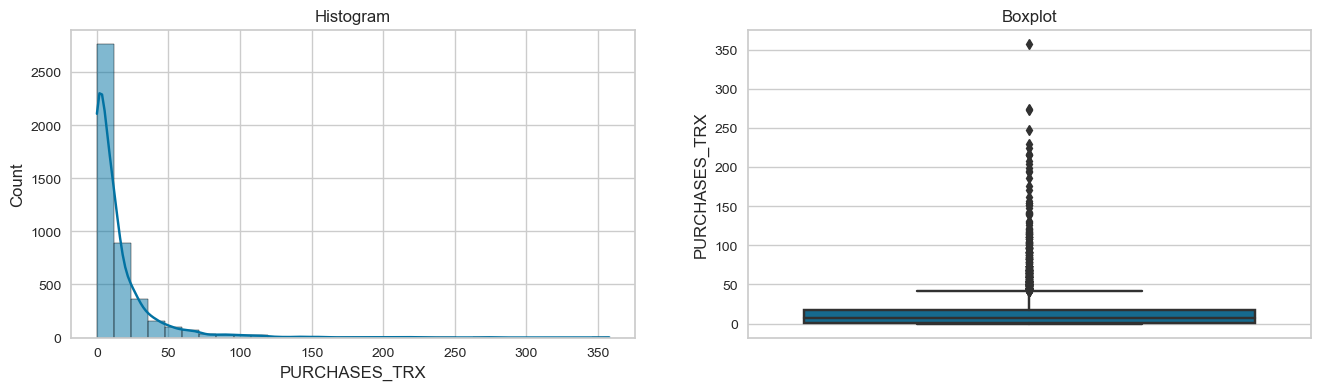

CREDIT_LIMIT
% Upper Outlier for CREDIT_LIMIT : 3.62%
% Lower Outlier for CREDIT_LIMIT : 0.00%
Skewness of CREDIT_LIMIT : 1.55


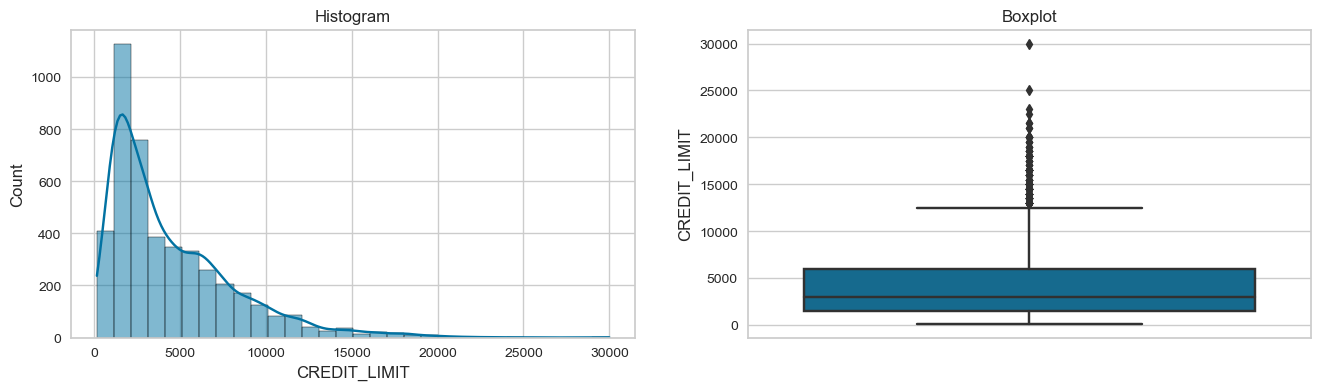

PAYMENTS
% Upper Outlier for PAYMENTS : 8.83%
% Lower Outlier for PAYMENTS : 0.00%
Skewness of PAYMENTS : 6.04


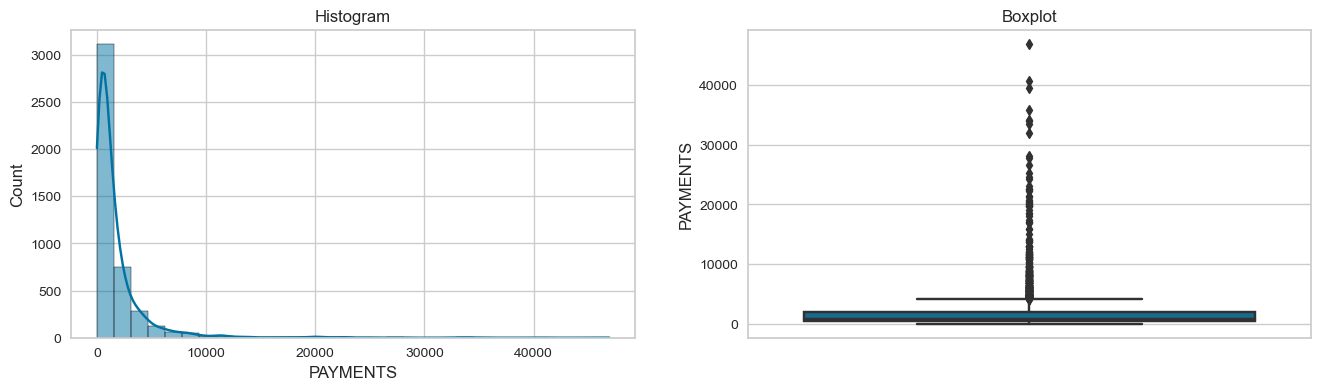

MINIMUM_PAYMENTS
% Upper Outlier for MINIMUM_PAYMENTS : 9.59%
% Lower Outlier for MINIMUM_PAYMENTS : 0.00%
Skewness of MINIMUM_PAYMENTS : 12.57


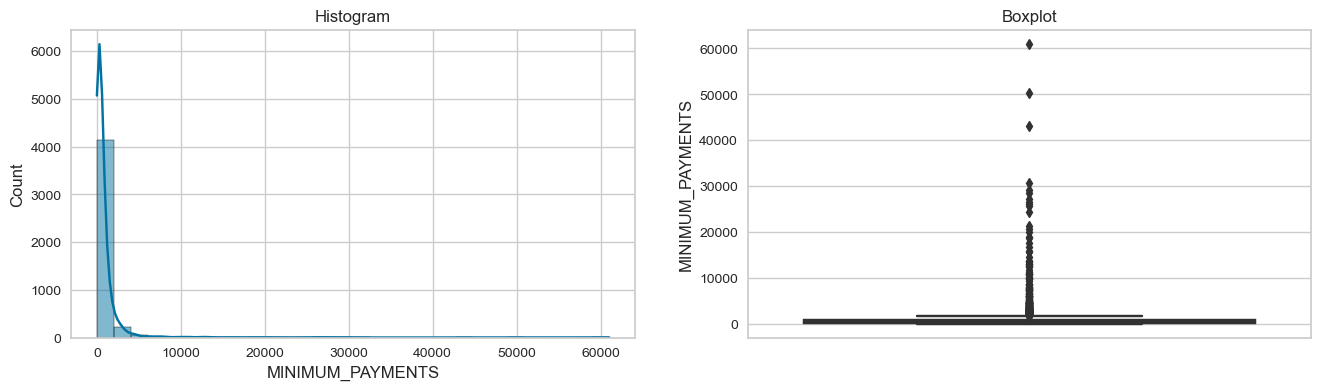

PRC_FULL_PAYMENT
% Upper Outlier for PRC_FULL_PAYMENT : 15.31%
% Lower Outlier for PRC_FULL_PAYMENT : 0.00%
Skewness of PRC_FULL_PAYMENT : 1.91


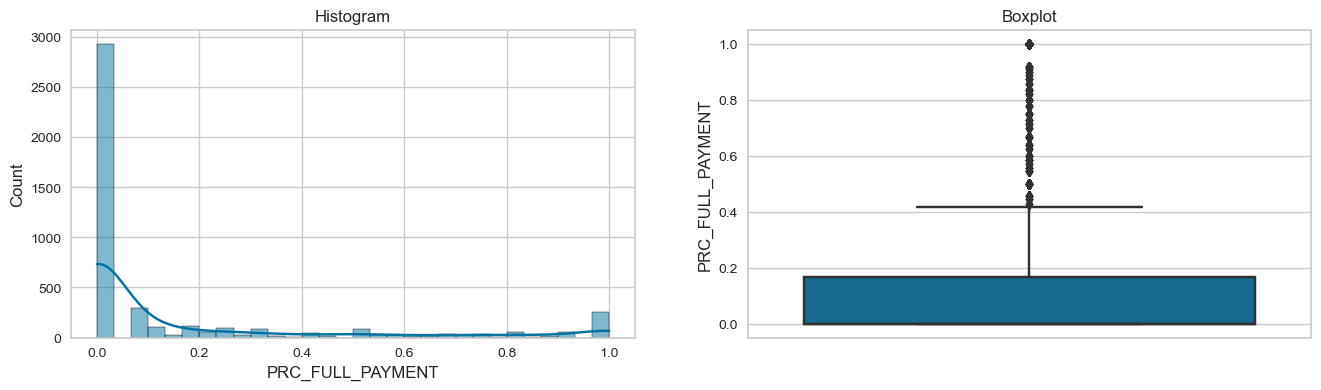

TENURE
% Upper Outlier for TENURE : 0.00%
% Lower Outlier for TENURE : 14.93%
Skewness of TENURE : -2.93


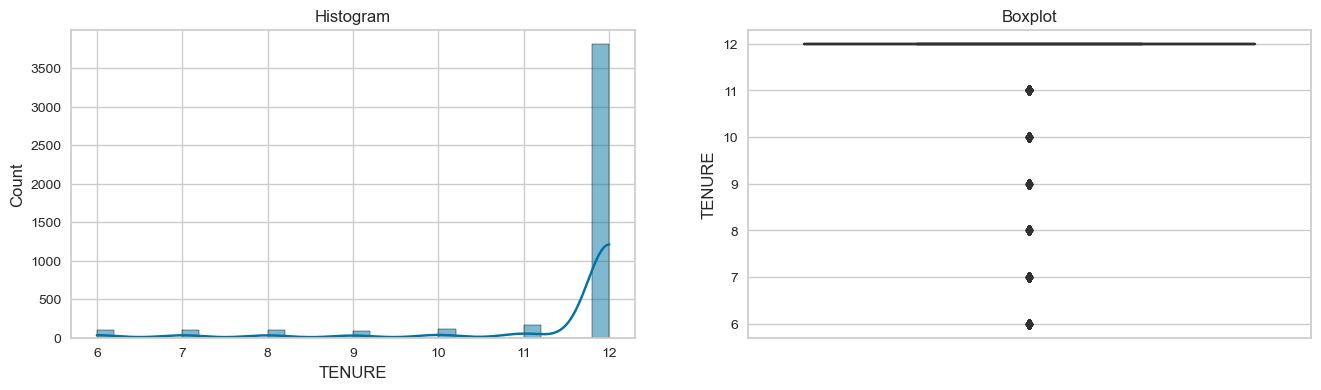

In [17]:
# Check the outlier in train data
for i in num_cols:
    globals()['Upper_'+i], globals()['Lower_'+i]=outlier_func.find_skewed_boundaries(df, i, 1.5,df[i].skew())
    upper=globals()['Upper_'+i]
    lower=globals()['Lower_'+i]
    
    out_u=(len(df[df[i] > upper])/len(df) * 100)
    out_l=(len(df[df[i] < lower])/len(df) * 100)
    
    print(i)
    print('% Upper Outlier for '+i+' : {:.2f}%'.format(out_u))
    print('% Lower Outlier for '+i+' : {:.2f}%'.format(out_l))
    print('Skewness of '+i+' : {:.2f}'.format(df[i].skew()))
    outlier_func.diagnostic_plots(df, i)
        

Menurut plot di atas, hampir semua data numerikal terdapat data outlier, namun untuk tenure dengan nilai maksimal 12 dan minimum 6 merupakan hal yang lumrah dalam aturan tenure credit card, sehingga tidak akan dilakukan handling outlier untuk feature tenure. Selanjutnya, untuk feature credit limit dan balance akan dicek terlebih dahulu apakah ini merupakan natural outlier atau tidak.

In [18]:
# Mengecek client yang merupakan termasuk kategori outlier menurut feature credit limit
df.loc[df['CREDIT_LIMIT']>25000]

CUST_ID      BALANCE  PURCHASES  ONEOFF_PURCHASES  \
4176   8760.0  1409.256223    4569.65           1748.94   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
4176                 2820.71   3883.517967                  0.7   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
4176                         0.6                               0.6   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
4176                     0.4               5.0           24.0       30000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
4176  5772.813158        472.103929               0.0    10.0

Selanjutnya, akan dilihat posisi outlier ini dari scatter plot.

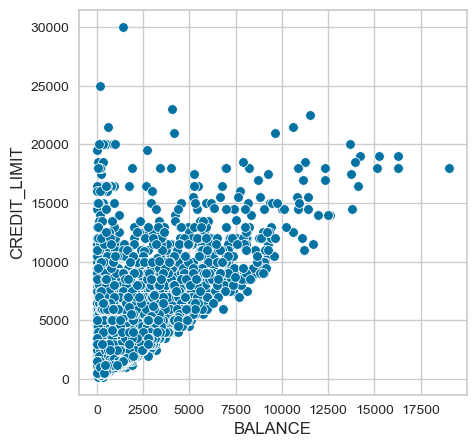

In [20]:
# Melihat korelasi antara semua fitur terhadap death event
plt.figure(figsize=(5,5))
sns.scatterplot(data=df, x='BALANCE', y="CREDIT_LIMIT")
plt.grid(True)

Semakin besar balance, semakin kecil juga sisa credit limit pada clients, sehingga jika dilihat pada outlier di balance dan credit_limit, sangat mungkin terjadi outlier untuk beberapa pelanggan.

Pada aplikasinya, kemungkinan terjadi natural outlier pada balance dan credit limit yang besar mungkin akan terjadi, namun untuk menganalisis ke segmentasi pelanggan, sulit menentukan segmentasi dari natural outlier yang seperti ini, sehingga semua outlier akan dihandle baik dengan trim (outlier kurang dari 5%) maupun di-censor (outlier yang lebih dari 5%).

In [21]:
#Trimming the outlier less than 5%

# Flag the outliers
for i in ['CREDIT_LIMIT']:
    globals()['outliers_'+i] = np.where(df[i] > globals()['Upper_'+i], True,
                       np.where(df[i] < globals()['Lower_'+i], True, False))

# Let's trimm the dataset
df_trimmed = df.loc[~(outliers_CREDIT_LIMIT)]
print('Rows dataset - Before trimming : ', df.shape[0])
print('Rows dataset - After trimming  : ', df_trimmed.shape[0])

Rows dataset - Before trimming :  4475
Rows dataset - After trimming  :  4313


In [22]:
# Create the capper

windsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['BALANCE', 'PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES',
                              'CASH_ADVANCE','ONEOFF_PURCHASES_FREQUENCY','CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PAYMENTS', 
                                     'MINIMUM_PAYMENTS','PRC_FULL_PAYMENT' ])

windsoriser.fit(df_trimmed)

df_capped = windsoriser.transform(df_trimmed)


BALANCE - After Capping


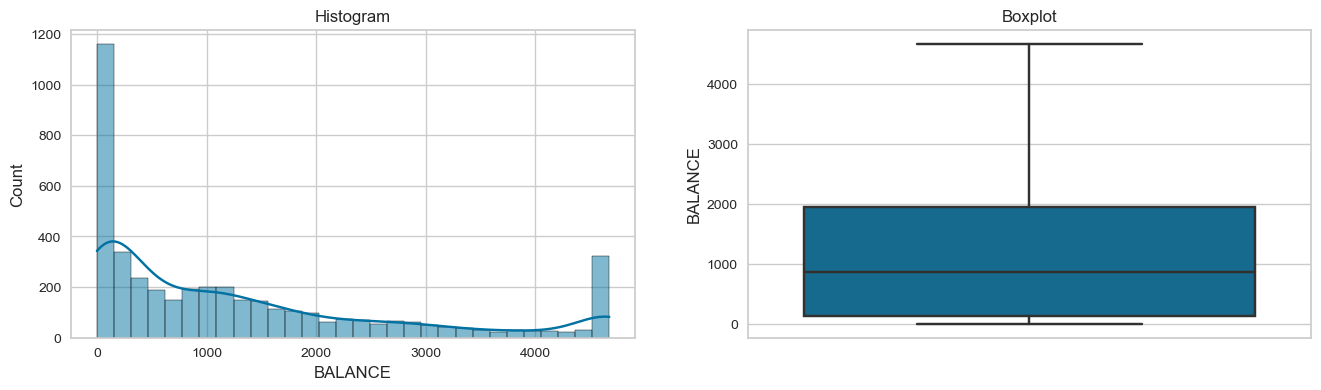


PURCHASES - After Capping


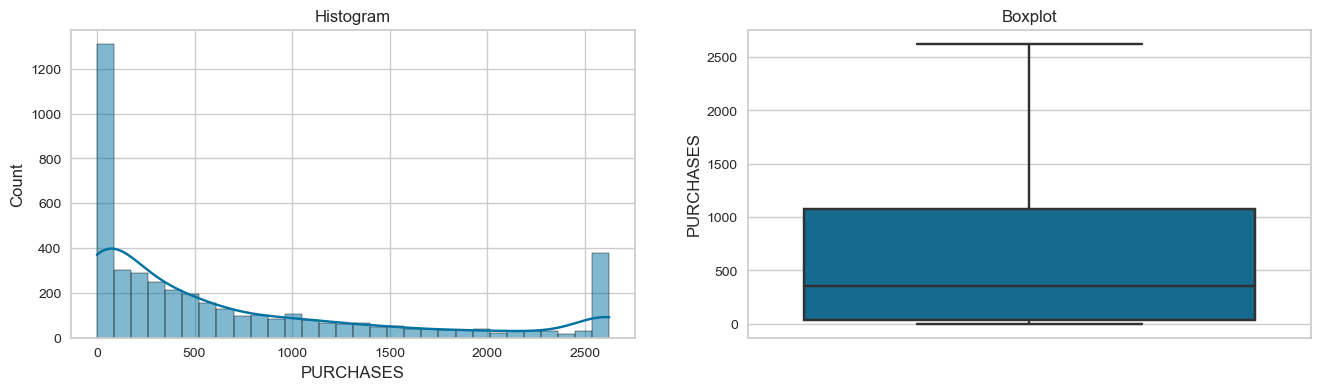


ONEOFF_PURCHASES - After Capping


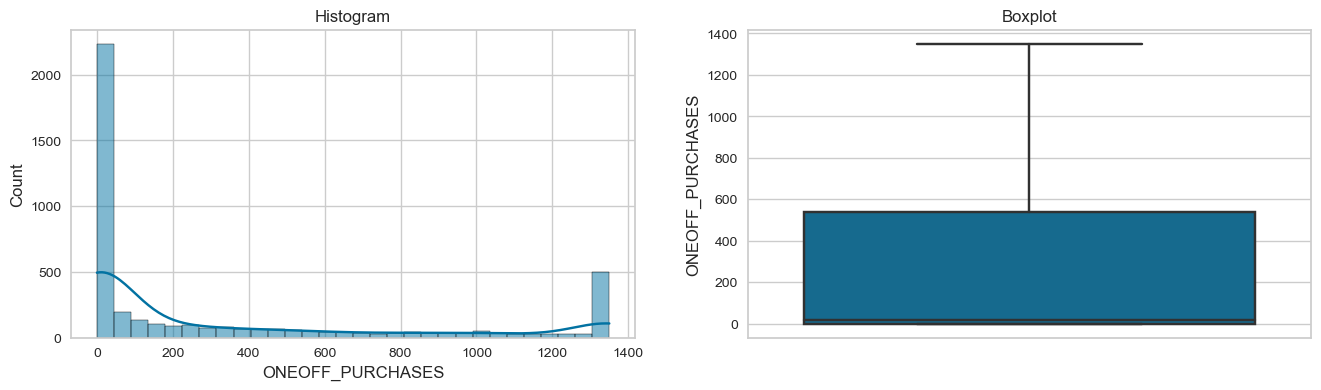


INSTALLMENTS_PURCHASES - After Capping


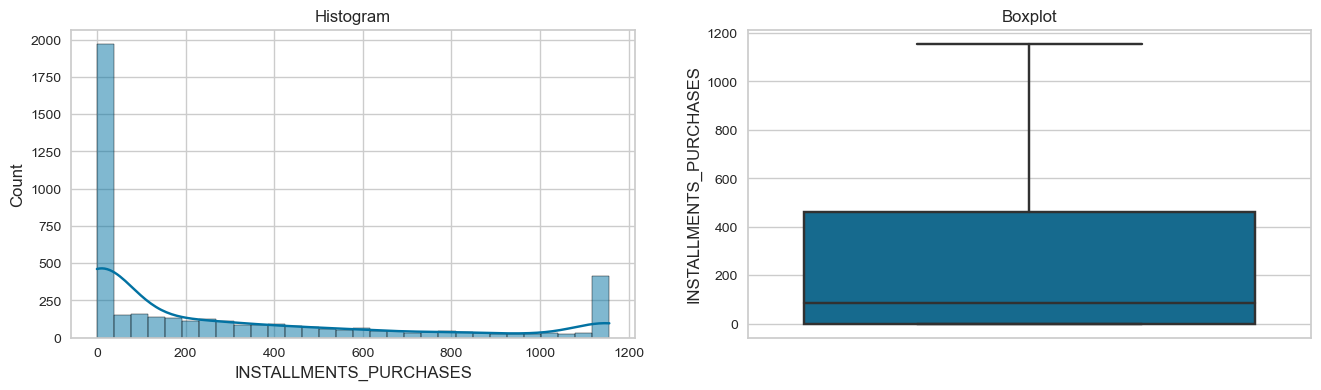


CASH_ADVANCE - After Capping


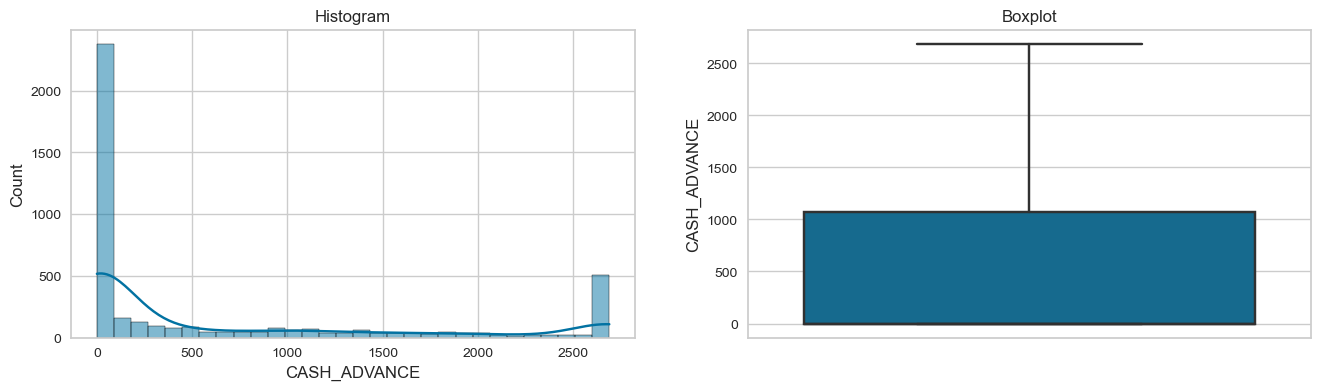


PURCHASES_FREQUENCY - After Capping


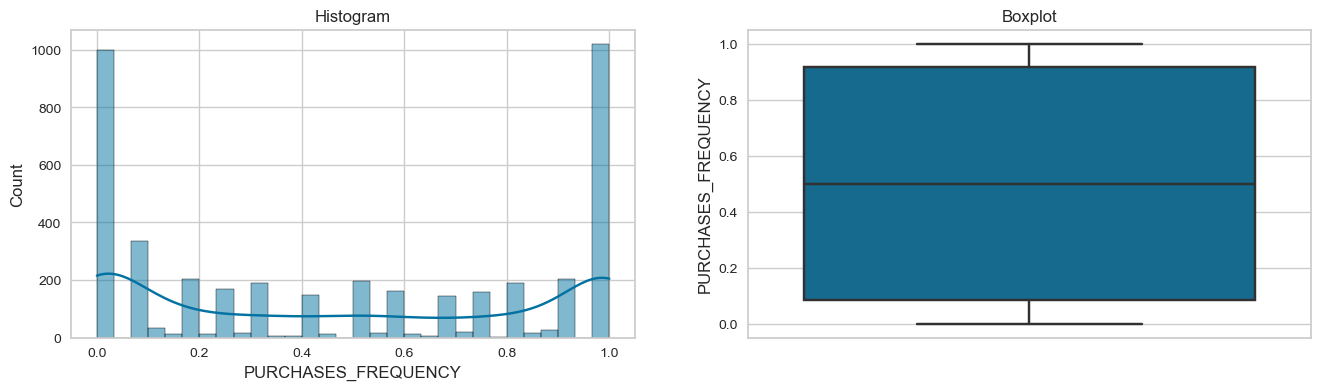


ONEOFF_PURCHASES_FREQUENCY - After Capping


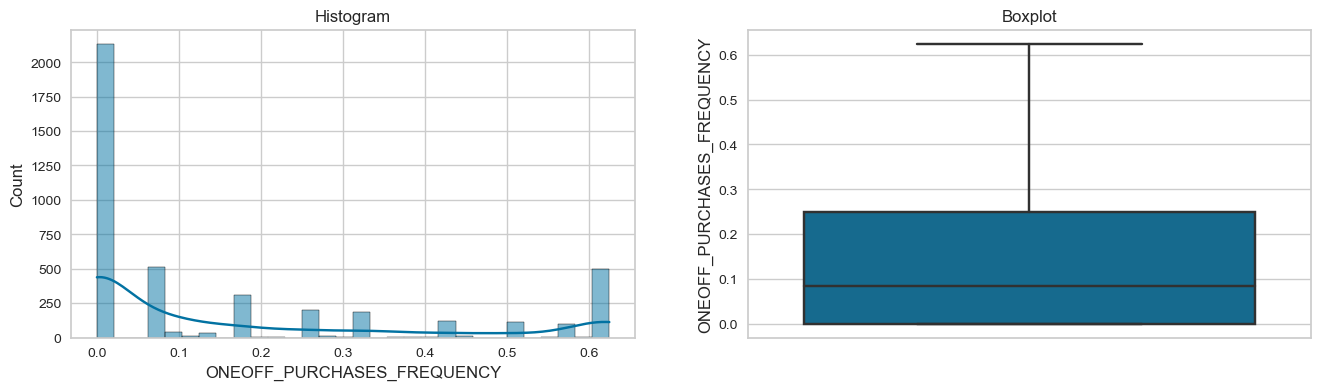


PURCHASES_INSTALLMENTS_FREQUENCY - After Capping


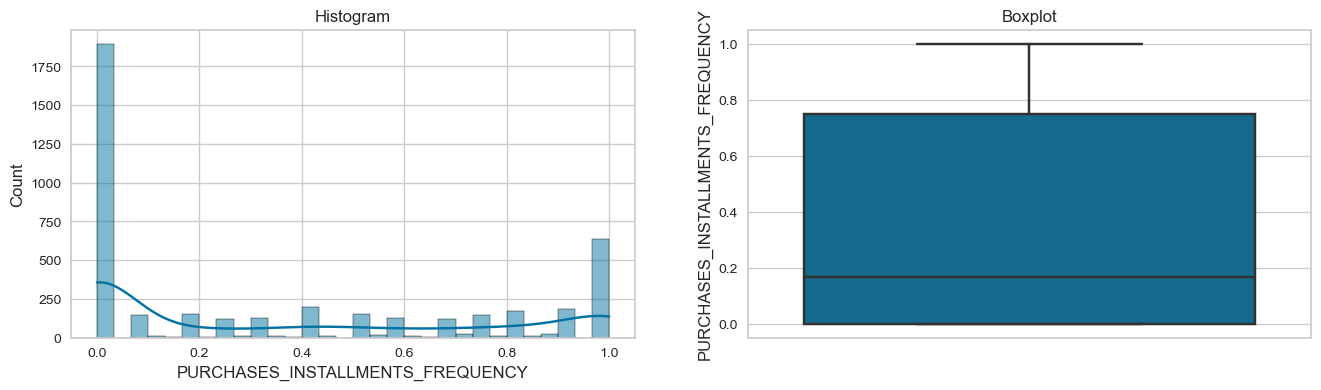


CASH_ADVANCE_FREQUENCY - After Capping


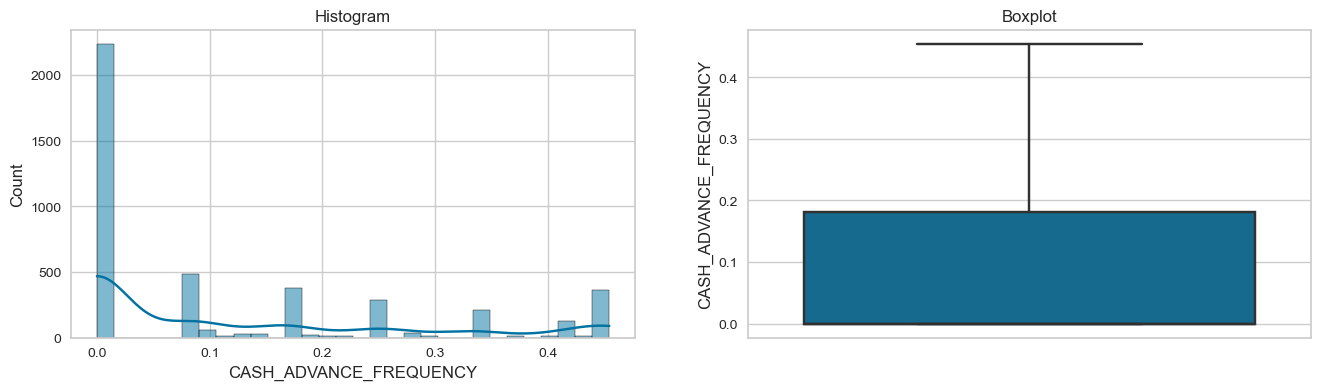


CASH_ADVANCE_TRX - After Capping


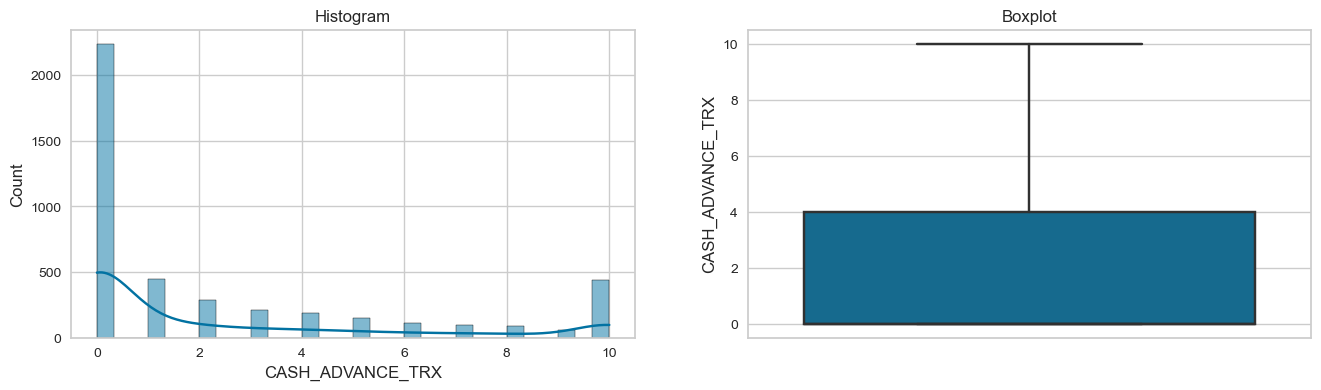


PURCHASES_TRX - After Capping


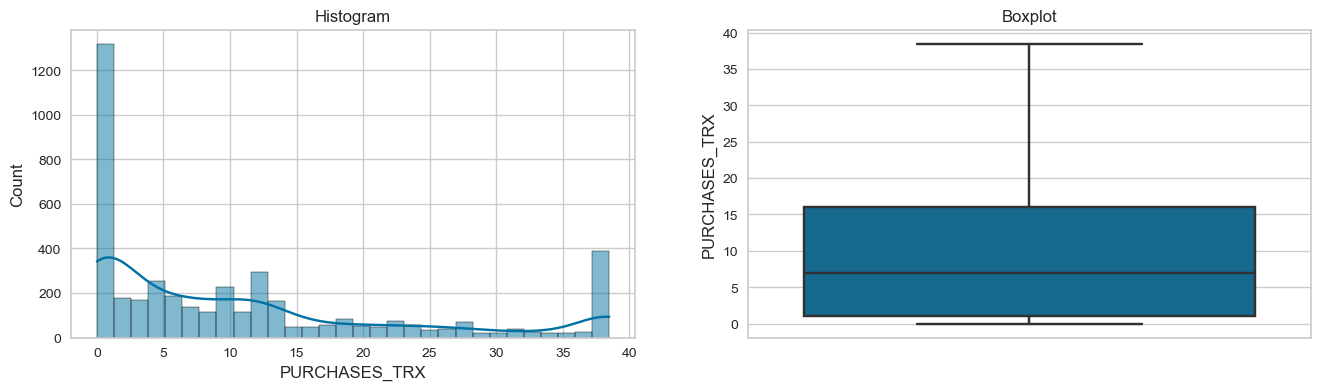


CREDIT_LIMIT - After Trimming


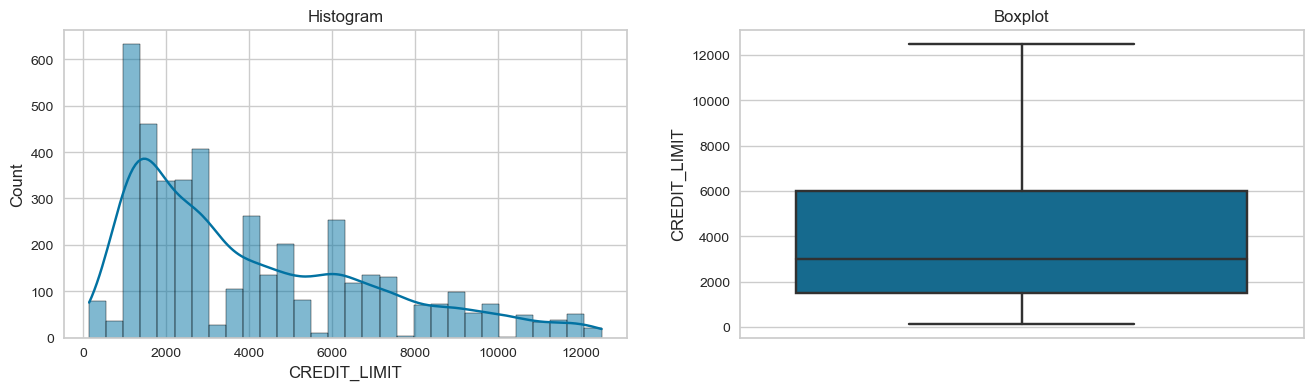


PAYMENTS - After Capping


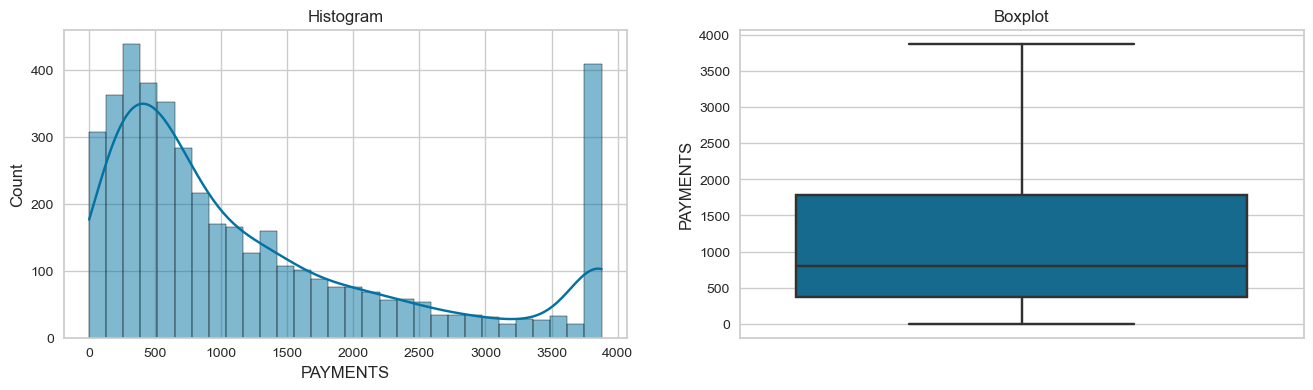


MINIMUM_PAYMENTS - After Capping


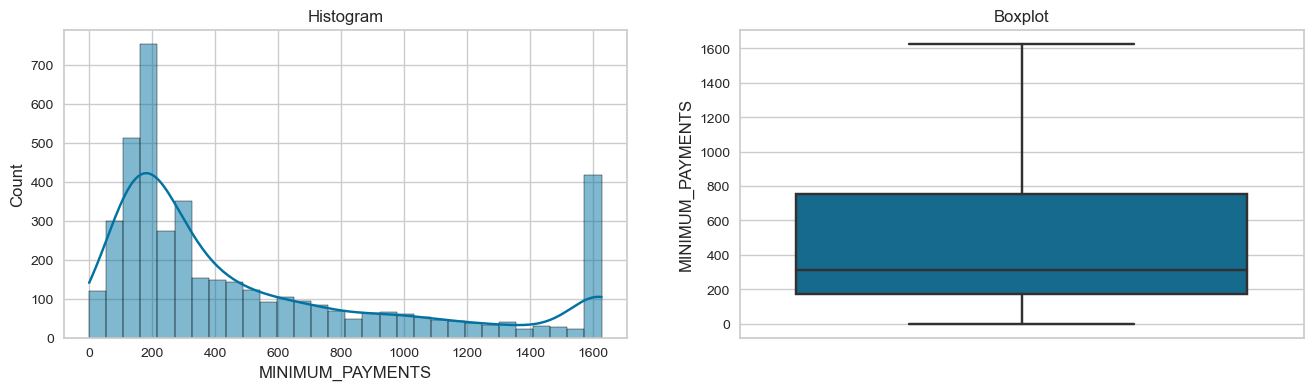


PRC_FULL_PAYMENT - After Capping


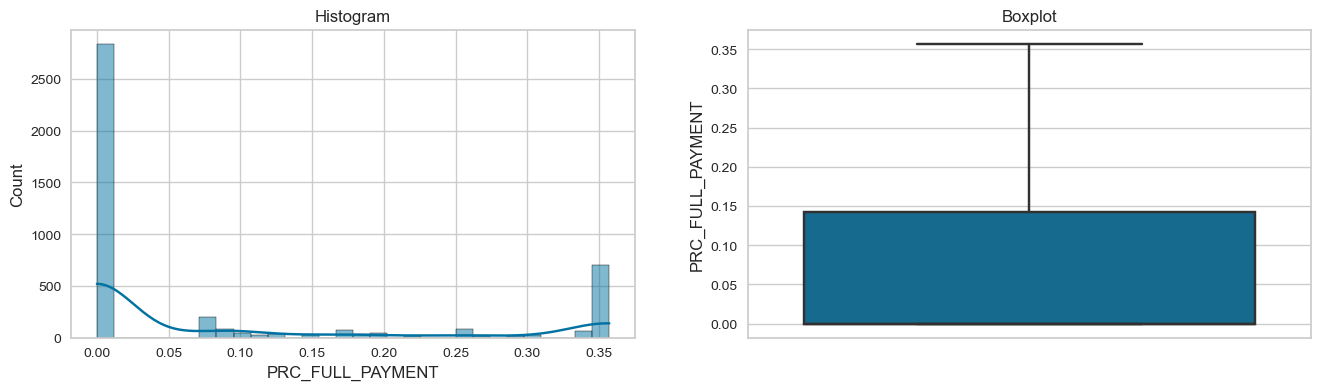


TENURE - After Capping


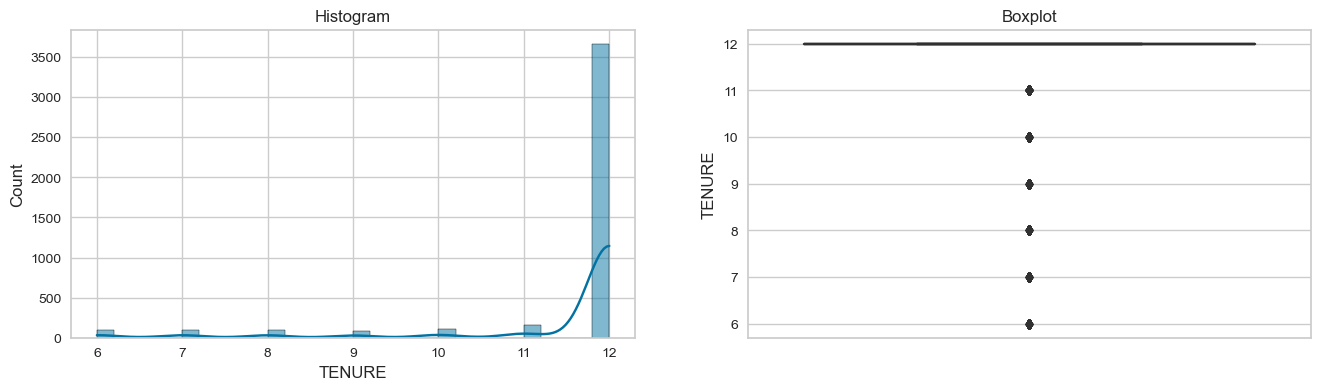

In [23]:
# Check the distribution of the data, after handling outlier
for i in num_cols:
    if (i=='CREDIT_LIMIT'):
        print('\n'+i+' - After Trimming')
        outlier_func.diagnostic_plots(df_capped, i)
    else:
        print('\n'+i+' - After Capping')
        outlier_func.diagnostic_plots(df_capped, i)

## Feature Scaling

In [26]:
# Split Train-Set based on Column Types

df_num = df_capped[num_cols]

In [27]:
# Define the scaler
scaler = MinMaxScaler()

#Fit and transform the scaler
scaler.fit(df_num)
df_num_scaled = scaler.transform(df_num)
df_num_scaled=pd.DataFrame(df_num_scaled, columns=num_cols)
df_num_scaled

BALANCE  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
0     0.003548   0.076210          0.000000                0.172924   
1     0.201906   0.039248          0.076296                0.000000   
2     0.000424   0.030484          0.059259                0.000000   
3     0.098741   0.222914          0.433333                0.000000   
4     0.225446   0.552523          1.000000                0.000000   
...        ...        ...               ...                     ...   
4308  0.230884   0.000000          0.000000                0.000000   
4309  0.173233   0.000000          0.000000                0.000000   
4310  0.724634   0.213762          0.316459                0.115652   
4311  1.000000   0.608130          1.000000                0.000000   
4312  0.423036   0.393259          0.168074                0.696142   

      CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
0         0.000000             0.125000                    0.000000   
1         0.000000             0.125000                    0.200000   
2         0.000000             0.125000                    0.200000   
3         0.000000             0.125000                    0.200000   
4         0.000000             0.125000                    0.200000   
...            ...                  ...                         ...   
4308      0.468102             0.000000                    0.000000   
4309      1.000000             0.000000                    0.000000   
4310      0.746301             1.000000                    1.000000   
4311      1.000000             0.454545                    0.727272   
4312      1.000000             0.909091                    0.145454   

      PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
0                             0.125000                     0.0   
1                             0.000000                     0.0   
2                             0.000000                     0.0   
3                             0.000000                     0.0   
4                             0.000000                     0.0   
...                                ...                     ...   
4308                          0.000000                     1.0   
4309                          0.000000                     1.0   
4310                          0.363636                     1.0   
4311                          0.000000                     1.0   
4312                          0.818182                     1.0   

      CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS  \
0                  0.0       0.051948      0.085020  0.000000   
1                  0.0       0.025974      0.068826  0.055515   
2                  0.0       0.025974      0.109312  0.000000   
3                  0.0       0.025974      0.068826  0.066526   
4                  0.0       0.025974      0.109312  0.102377   
...                ...            ...           ...       ...   
4308               0.9       0.000000      0.085020  0.355696   
4309               0.7       0.000000      0.323887  1.000000   
4310               0.9       0.519481      0.805668  0.267874   
4311               1.0       0.649351      0.473684  0.233544   
4312               1.0       0.441558      0.311741  0.788004   

      MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0             0.190292          0.000000  0.333333  
1             0.252100          0.000000  0.333333  
2             0.190292          0.000000  0.333333  
3             0.093150          0.000000  0.333333  
4             0.139490          0.000000  0.333333  
...                ...               ...       ...  
4308          0.166651          0.254545  0.833333  
4309          0.148398          0.254545  0.833333  
4310          0.544197          0.000000  0.833333  
4311          1.000000          0.254545  0.833333  
4312          0.559341          0.254545  0.833333  

[4313 rows x 16 columns]

## Check Multicollinearity

In [28]:
#Cek Multicollinearity

vif_data = pd.DataFrame()
vif_data["feature"] = num_cols
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(len(num_cols))]

vif_data

feature        VIF
0                            BALANCE   9.147372
1                          PURCHASES  25.621920
2                   ONEOFF_PURCHASES  15.442082
3             INSTALLMENTS_PURCHASES  11.272066
4                       CASH_ADVANCE   5.001281
5                PURCHASES_FREQUENCY  25.931039
6         ONEOFF_PURCHASES_FREQUENCY  10.530964
7   PURCHASES_INSTALLMENTS_FREQUENCY  22.203919
8             CASH_ADVANCE_FREQUENCY  11.793885
9                   CASH_ADVANCE_TRX  12.146595
10                     PURCHASES_TRX  11.229014
11                      CREDIT_LIMIT   5.127467
12                          PAYMENTS   4.233884
13                  MINIMUM_PAYMENTS   7.329545
14                  PRC_FULL_PAYMENT   2.168668
15                            TENURE   6.399765

- Hanya ada 7 feature yang tidak saling berkaitan dengan feature lainnya melihat dari nilai VIF, yaitu BALANCE, CASH_ADVANCE, CREDIT_LIMIT, PAYMENTS, MINIMUM_PAYMENTS, PRC_FULL_PAYMENT, dan TENURE
- Dapat diprediksi bahwa jika dilakukan reduksi dimensi, maka paling tidak dapat direduksi sampai 7 dimensi

## Dimension Reduction

### Using PCA

In [29]:
# Fitting the pca models
pca = PCA()
pca.fit(df_num_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
d

5

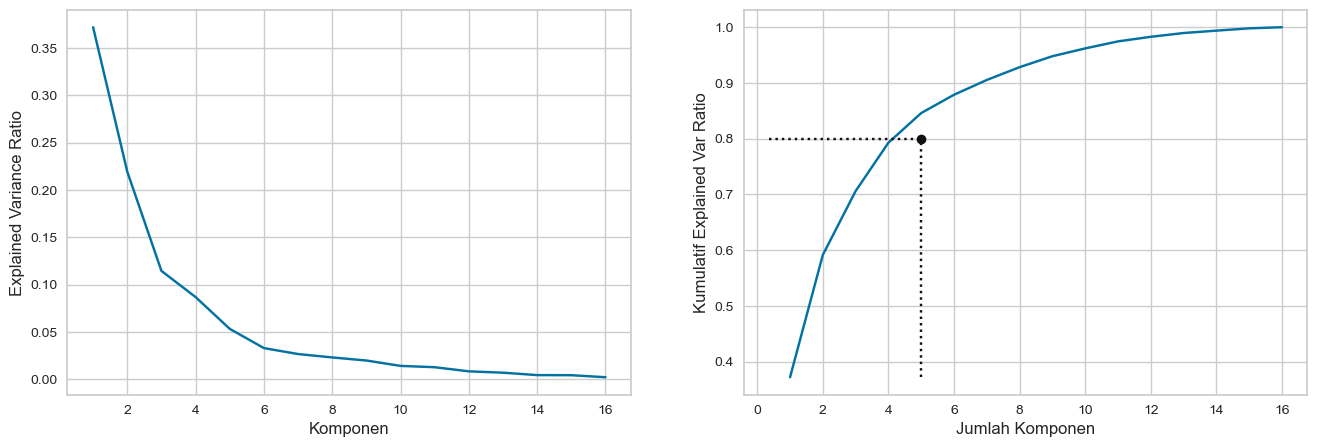

In [31]:
# Menggunakan pca
pca_scaled=PCA().fit(df_num_scaled)

fig,ax=plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,17),pca_scaled.explained_variance_ratio_)
ax[0].set_xlabel('Komponen')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].grid(True)

ax[1].plot(range(1,17),np.cumsum(pca_scaled.explained_variance_ratio_))
ax[1].set_xlabel('Jumlah Komponen')
ax[1].set_ylabel('Kumulatif Explained Var Ratio')
ax[1].plot([5, 5], [np.cumsum(pca_scaled.explained_variance_ratio_).min(), 0.8], "k:")
ax[1].plot([np.cumsum(pca_scaled.explained_variance_ratio_).min(), 5], [0.8, 0.8], "k:")
ax[1].plot(5, 0.8, "ko")
plt.grid(True)
plt.show()

Hasil plot explained ratio menunjukkan jumlah komponen yang pas adalah dengan menggunakan 4 dimensi.

### Using Kernel Poly PCA

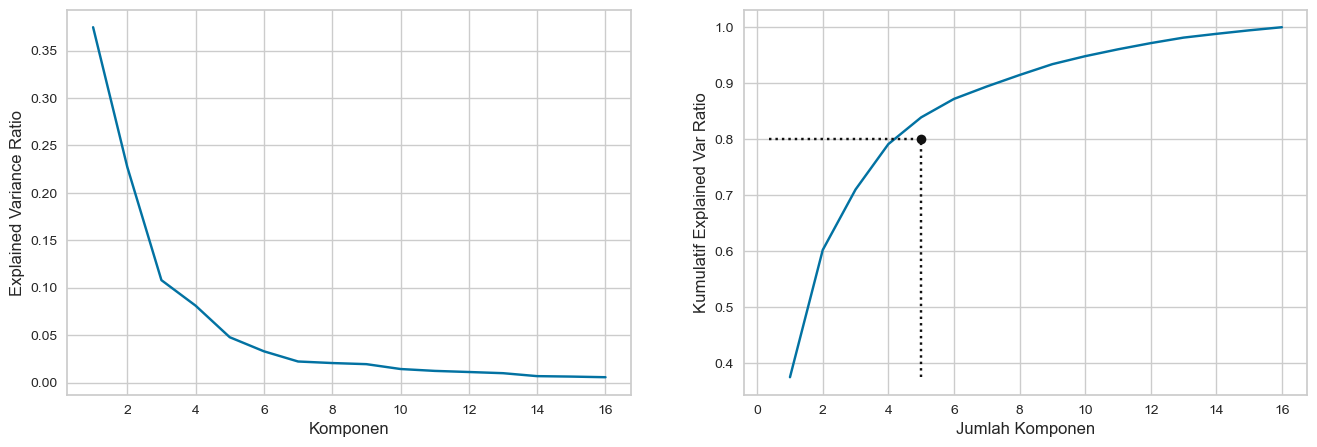

In [32]:
# Menggunakan Kernel Poly PCA
kpca_17d=KernelPCA(n_components=16,kernel='poly').fit_transform(df_num_scaled)

ev_kpca_17d = np.var(kpca_17d, axis=0)
evr_kpca_17d = ev_kpca_17d / np.sum(ev_kpca_17d)

fig,ax=plt.subplots(ncols=2,figsize=(16,5))
ax[0].plot(range(1,17),evr_kpca_17d)
ax[0].set_xlabel('Komponen')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].grid(True)

ax[1].plot(range(1,17),np.cumsum(evr_kpca_17d))
ax[1].set_xlabel('Jumlah Komponen')
ax[1].set_ylabel('Kumulatif Explained Var Ratio')
ax[1].plot([5, 5], [np.cumsum(evr_kpca_17d).min(), 0.8], "k:")
ax[1].plot([np.cumsum(evr_kpca_17d).min(), 5], [0.8, 0.8], "k:")
ax[1].plot(5, 0.8, "ko")
plt.grid(True)
plt.show()

Hasil plot explained ratio menunjukkan jumlah komponen yang pas adalah dengan menggunakan 4 dimensi.

## Save the final pre-processed data (PCA)

In [33]:
# Menyimpan hasil pca ke dalam dataframe
pca_final=PCA(n_components=4)
kpca_final=KernelPCA(n_components=4,kernel='poly')
df_pca=pd.DataFrame(pca_final.fit_transform(df_num_scaled),columns=['PC1','PC2','PC3','PC4'])
df_kpca_poly=pd.DataFrame(kpca_final.fit_transform(df_num_scaled),
                          columns=['PC1','PC2','PC3','PC4'])

In [34]:
# Concate the df_final
df_final_pca=pd.concat([df_pca], axis=1)
df_final_kpca_poly=pd.concat([df_kpca_poly], axis=1)
df_final_pca

PC1       PC2       PC3       PC4
0    -0.455116 -0.754933 -0.121455 -0.245129
1    -0.522990 -0.611404 -0.347292 -0.268543
2    -0.511778 -0.722280 -0.355711 -0.213197
3    -0.352488 -0.571272 -0.569106 -0.166791
4    -0.111225 -0.278534 -0.880853 -0.163921
...        ...       ...       ...       ...
4308 -1.111626  0.199800  0.160546  0.492831
4309 -1.108572  0.538335  0.185494  0.770420
4310 -0.071799  1.280127  0.044474  0.026090
4311 -0.312225  1.714995 -0.387551  0.196475
4312  0.035262  1.159252  0.961366  0.413666

[4313 rows x 4 columns]

## Model Definition and Training

### Model Defnition with PCA-transformed data

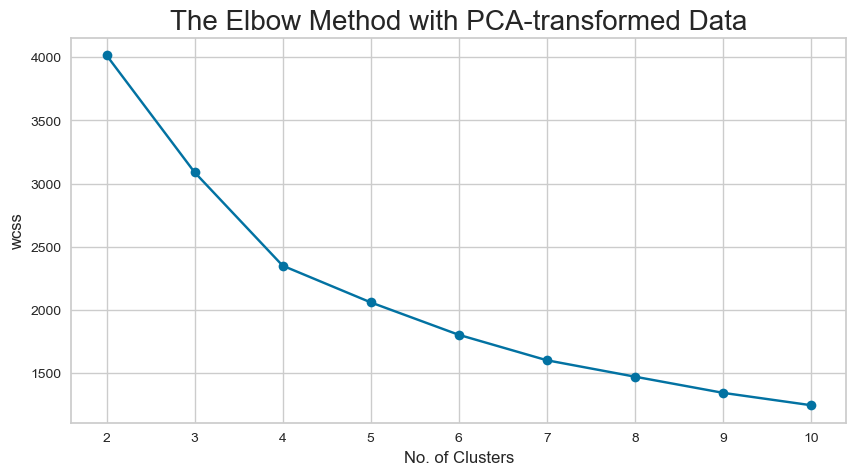

In [35]:
#Definisikan K-Means Clustering dengan mencari n_cluster terbaik versi ELbow dari data dari PCA
wcss = []
#membuat iterasi dari 2-10 untuk nilai k terbaik
for i in range(2, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
    km.fit(df_final_pca)
    wcss.append(km.inertia_)
    

plt.figure(figsize=(10,5))
plt.plot(range(2, 11), wcss, marker ="o")
plt.title('The Elbow Method with PCA-transformed Data', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.grid(True)
plt.show()

Menurut Elbow Method dari data PCA, didapat jumlah kluster sebanyak 4 kluster.

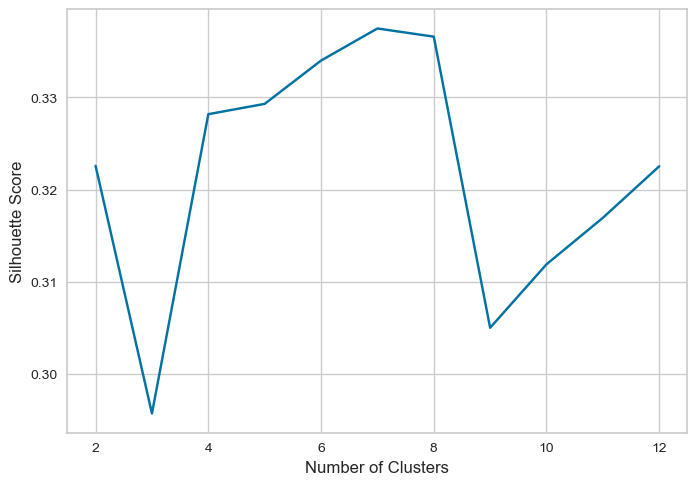

In [36]:
# Plot silhouette score
sil_scores=[]
for k in range(2,13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_final_pca)
    sil_score=silhouette_score(df_final_pca, kmeans.labels_)
    sil_scores.append(sil_score)
    
plt.plot(range(2,13),sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Hasil silhouette score-PCA merekomendasikan 7 jumlah cluster.

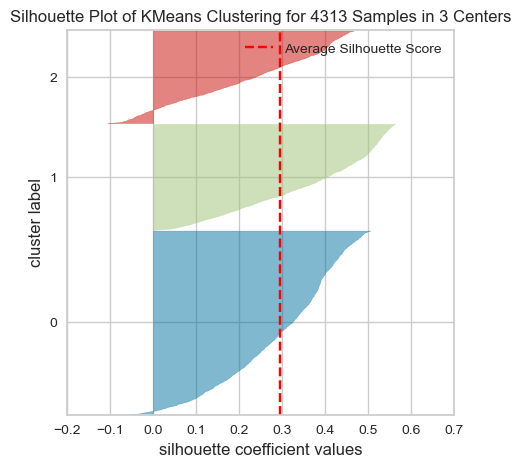

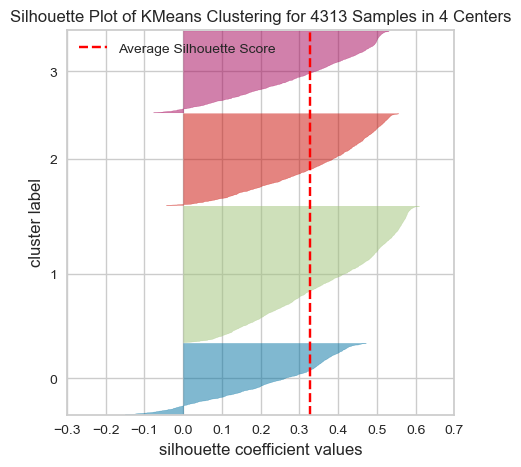

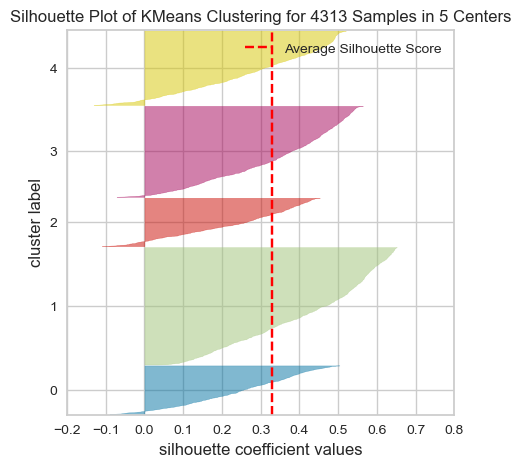

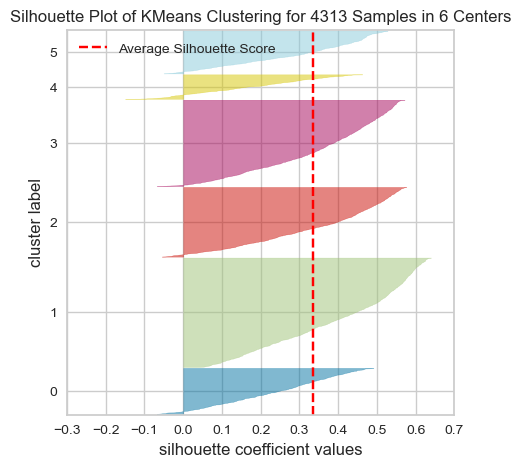

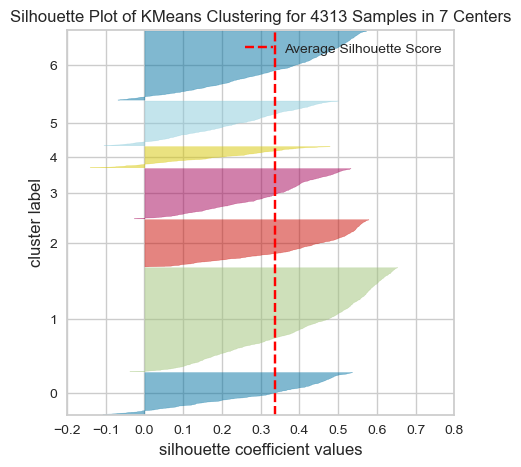

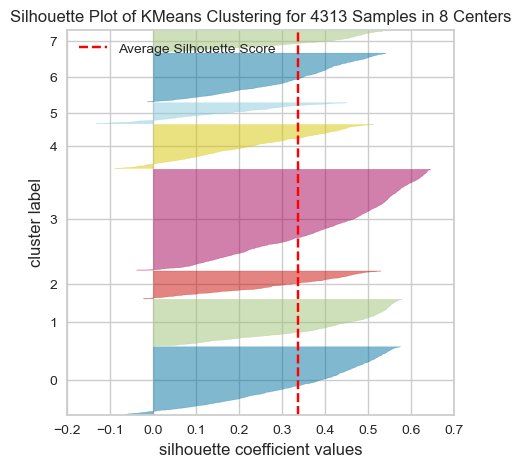

In [37]:
# Clustering with deduction using PCA
for i, n_cluster in enumerate(range(3,9)):

    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    
    plt.figure(figsize=(5,5))
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(df_final_pca)
    visualizer.show()

Dari silhouette score dan variance-nya, didapat bahwa jumlah kluster yang tepat adalah n=3.

### Model Defnition with KernelPCA data

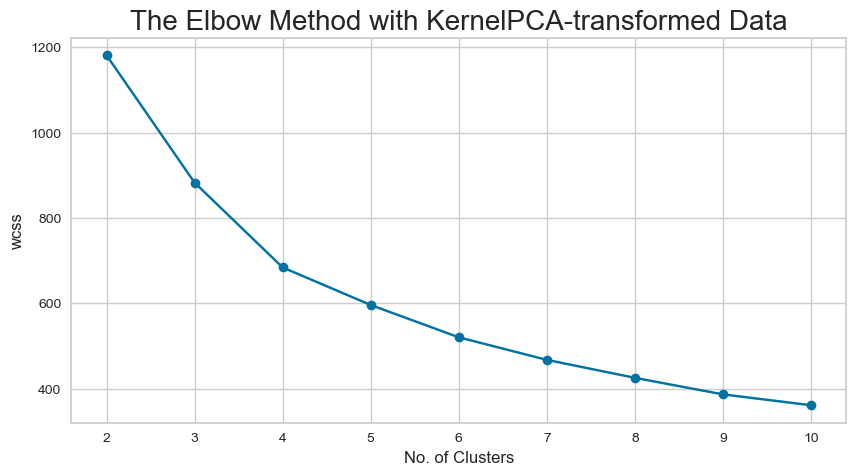

In [38]:
#Definisikan K-Means Clustering dengan mencari n_cluster terbaik versi ELbow dari data dari KernelPCA

wcss = []
#membuat iterasi dari 2-10 untuk nilai k terbaik
for i in range(2, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
    km.fit(df_final_kpca_poly)
    wcss.append(km.inertia_)
    

plt.figure(figsize=(10,5))
plt.plot(range(2, 11), wcss, marker ="o")
plt.title('The Elbow Method with KernelPCA-transformed Data', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.grid(True)
plt.show()

Menurut Elbow Method dari data KernelPoly PCA-transformed, didapat jumlah kluster sebanyak 4 kluster.

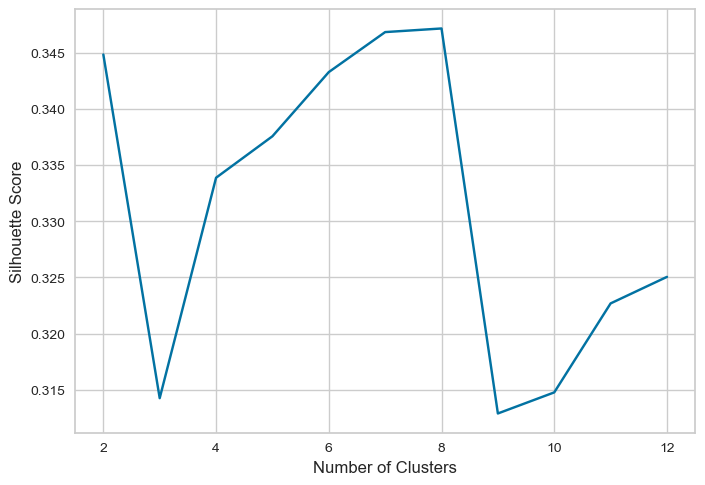

In [39]:
# Mencari silohuette score yang lebih besar dari elbow method
sil_scores=[]
for k in range(2,13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_final_kpca_poly)
    sil_score=silhouette_score(df_final_kpca_poly, kmeans.labels_)
    sil_scores.append(sil_score)
    
plt.plot(range(2,13),sil_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Hasil silhouette score-KernelPCA merekomendasikan 8 jumlah cluster.

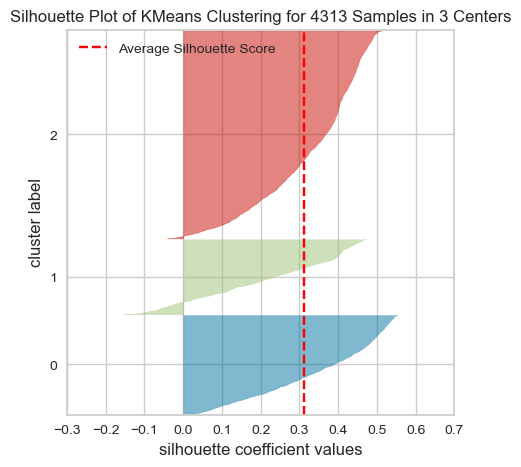

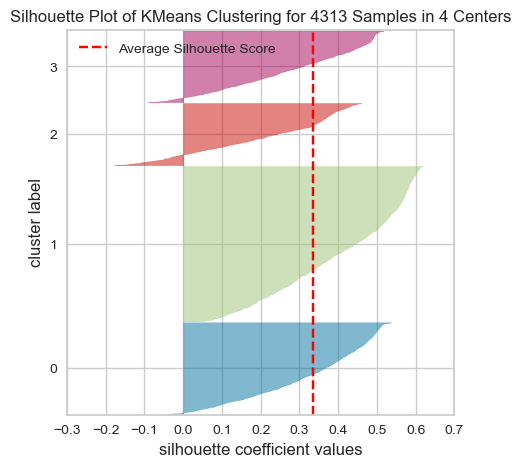

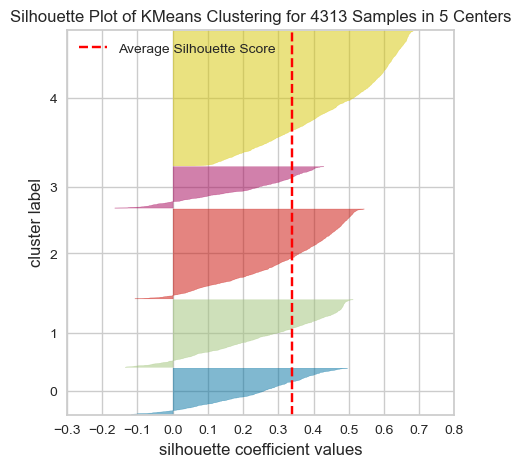

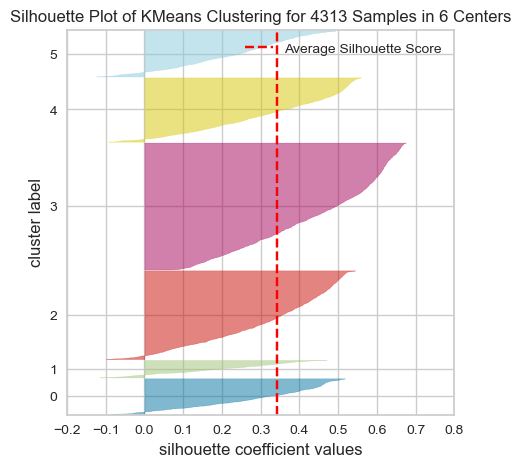

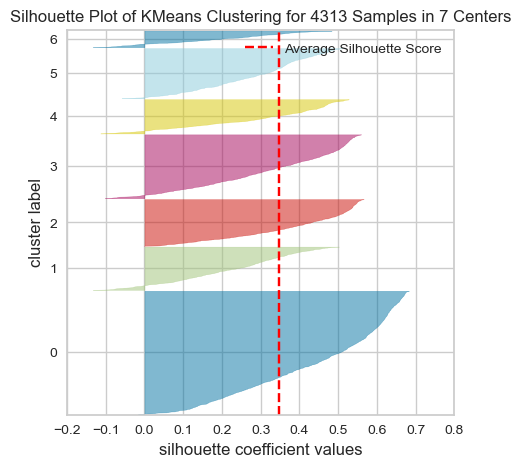

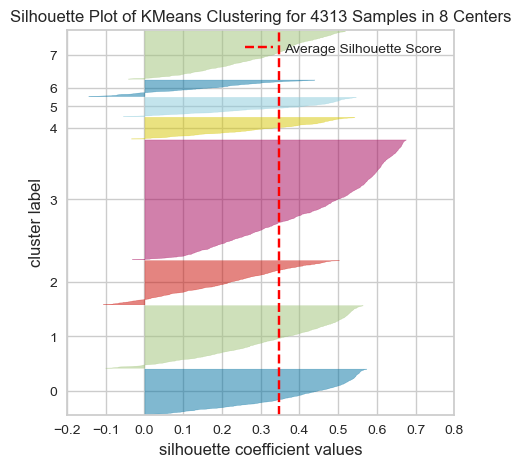

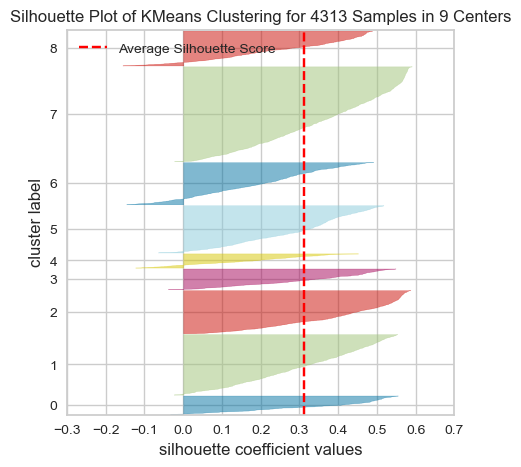

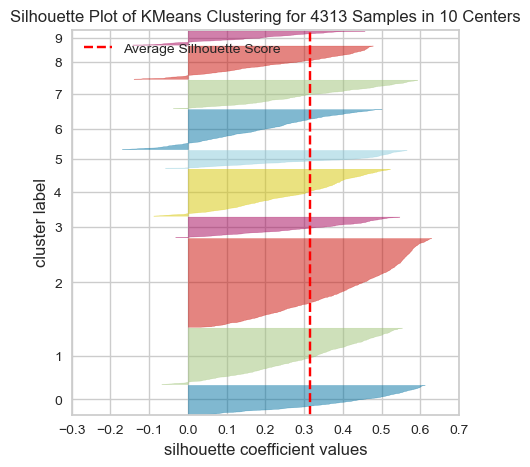

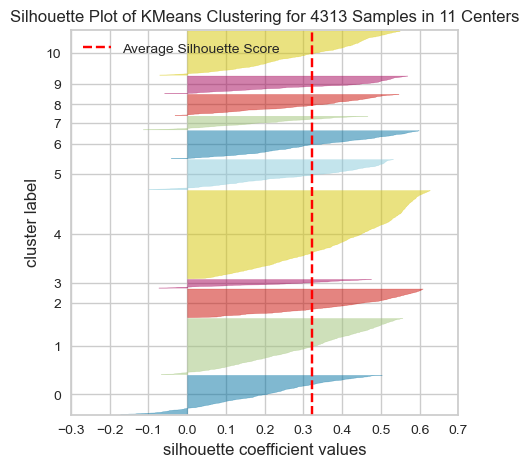

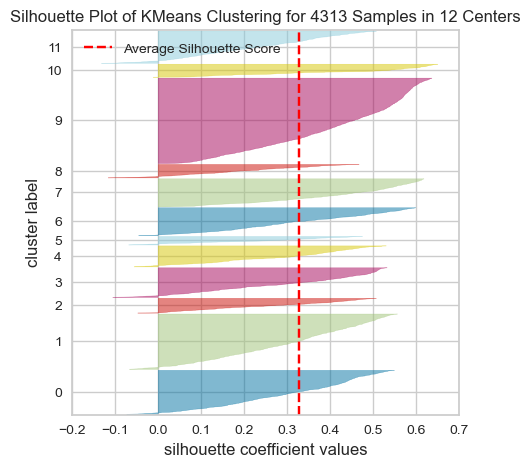

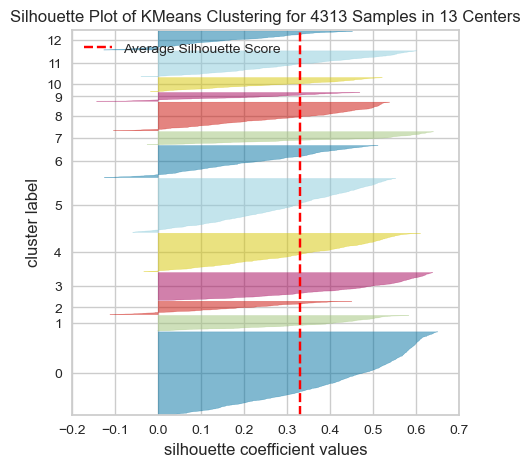

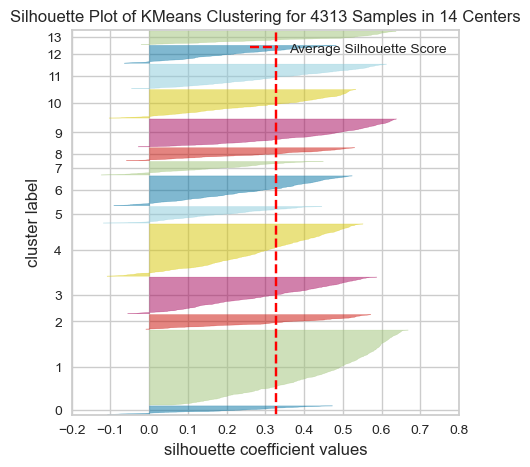

In [40]:
# Clustering with deduction using KernelPCA
for i, n_cluster in enumerate(range(3,15)):

    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    
    plt.figure(figsize=(5,5))
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(df_final_kpca_poly)
    visualizer.show()

Dari silhouette score dan variance-nya, didapat bahwa jumlah kluster yang tepat adalah n=4.\
__Kesimpulan__ : Dari hasil Elbow Method dan Silhouette Score, model K-Means menggunakan data hasil PCA dan KernelPCA-transform akan menggunakan jumlah cluster=3 dan cluster=4

## Analysis the Clusters Result with Dimension Reduction into 2D

Akan dilakukan clustering berdasarkan hasil training di atas berdasarkan silhotette score, yakni 3 cluster menggunakan data dari PCA-transformed dan KernelPCA-transformed.

In [41]:
# Clustering with K-means clusters with n_clusters=4 and using default PCA
km_pca1 = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
y_pred_pca1 = km_pca1.fit_predict(df_num_scaled)
df_cluster_pca1=df_num_scaled.copy()
df_cluster_pca1['clusters']=y_pred_pca1

# Clustering with K-means clusters with n_clusters=4 and using Kernel Poly PCA
km_kpca_poly1 = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
y_pred_kpca_poly1 = km_kpca_poly1.fit_predict(df_num_scaled)
df_cluster_kpca_poly1= df_num_scaled.copy()
df_cluster_kpca_poly1['clusters']=y_pred_kpca_poly1

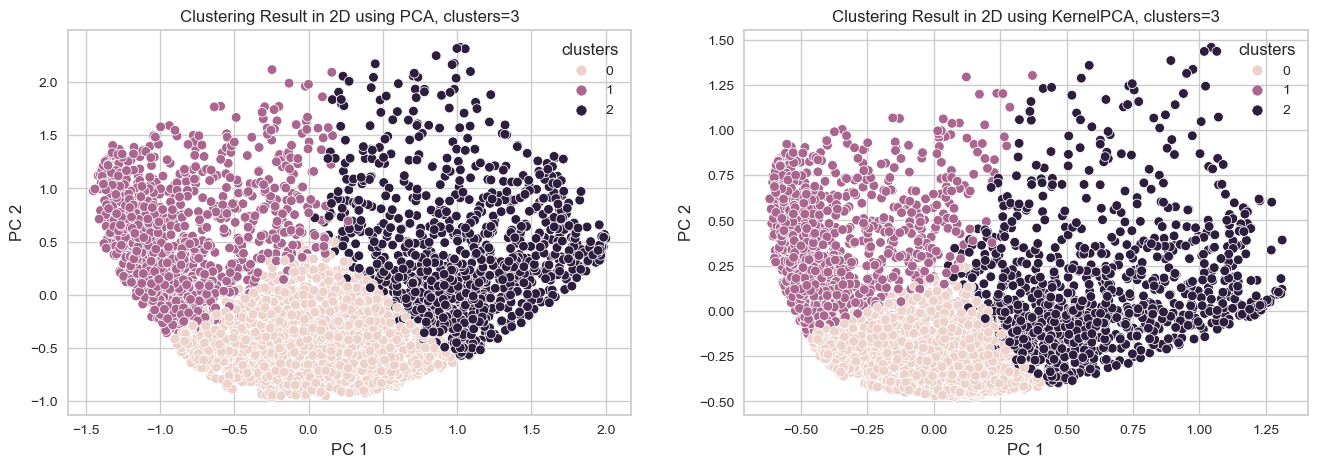

In [42]:
# dimension reduction into 2D using PCA
pca_2d=PCA(n_components=2).fit(df_num_scaled)
twod_pca=pca_2d.transform(df_num_scaled)

# dimension reduction into 2D using KernelPCA
kpca_2d=KernelPCA(n_components=2,kernel='poly').fit(df_num_scaled)
twod_kpca=kpca_2d.transform(df_num_scaled)

fig,ax=plt.subplots(ncols=2,figsize=(16,5))
sns.scatterplot(x=twod_pca[:,0],y=twod_pca[:,1], hue=df_cluster_pca1['clusters'], ax=ax[0])
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[0].set_title('Clustering Result in 2D using PCA, clusters=3')

sns.scatterplot(x=twod_kpca[:,0],y=twod_kpca[:,1], hue=df_cluster_kpca_poly1['clusters'], ax=ax[1])
ax[1].set_xlabel('PC 1')
ax[1].set_ylabel('PC 2')
ax[1].set_title('Clustering Result in 2D using KernelPCA, clusters=3')


plt.show()

- Menggunakan data yang di pca-transformed : pemisah jelas, distribusi sama
- Menggunakan data yang di kernel poly pca-transformed : pemisah jelas, distribusi hampir sama, beberapa persebaran terlihat adanya outlier

Akan dilakukan juga clustering berdasarkan hasil training dengan menggunakan acuan dari elbow method, yakni 4 cluster menggunakan data dari PCA-transformed dan KernelPCA-transformed.

In [43]:
# Clustering with K-means clusters with n_clusters=4 and using default PCA
km_pca2 = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
y_pred_pca2 = km_pca2.fit_predict(df_num_scaled)
df_cluster_pca2=df_num_scaled.copy()
df_cluster_pca2['clusters']=y_pred_pca2

# Clustering with K-means clusters with n_clusters=4 and using Kernel Poly PCA
km_kpca_poly2 = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
y_pred_kpca_poly2 = km_kpca_poly2.fit_predict(df_num_scaled)
df_cluster_kpca_poly2= df_num_scaled.copy()
df_cluster_kpca_poly2['clusters']=y_pred_kpca_poly2

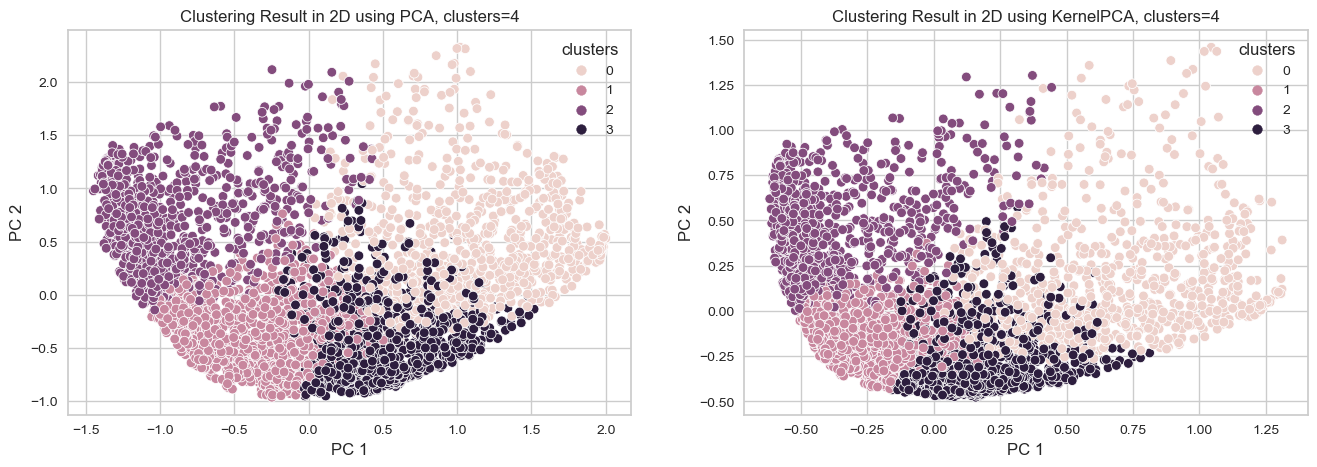

In [44]:
# dimension reduction into 2D using PCA
pca_2d=PCA(n_components=2).fit(df_num_scaled)
twod_pca=pca_2d.transform(df_num_scaled)

# dimension reduction into 2D using KernelPCA
kpca_2d=KernelPCA(n_components=2,kernel='poly').fit(df_num_scaled)
twod_kpca=kpca_2d.transform(df_num_scaled)

fig,ax=plt.subplots(ncols=2,figsize=(16,5))
sns.scatterplot(x=twod_pca[:,0],y=twod_pca[:,1], hue=df_cluster_pca2['clusters'], ax=ax[0])
ax[0].set_xlabel('PC 1')
ax[0].set_ylabel('PC 2')
ax[0].set_title('Clustering Result in 2D using PCA, clusters=4')

sns.scatterplot(x=twod_kpca[:,0],y=twod_kpca[:,1], hue=df_cluster_kpca_poly2['clusters'], ax=ax[1])
ax[1].set_xlabel('PC 1')
ax[1].set_ylabel('PC 2')
ax[1].set_title('Clustering Result in 2D using KernelPCA, clusters=4')


plt.show()

- Hasil cluster menggunakan PCA dan KernelPCA menggambarkan pemisah yang tidak dengan distribusi setiap cluster yang tidak balance (kurang baik)

__Kesimpulan__ :
Didapat bahwa kita memiliki 1 jenis cluster terbaik yang akan dianalisis hasil segmentasi pelanggannya, yaitu n_clusters=3 menggunakan PCA-transformed data.

## Exploratory Data Analysis With Clusters

In [45]:
# Skenario dengan n_cluster=4, menggunakan PCA
df_cluster3=df_capped.copy()
df_cluster3['clusters']=y_pred_pca1

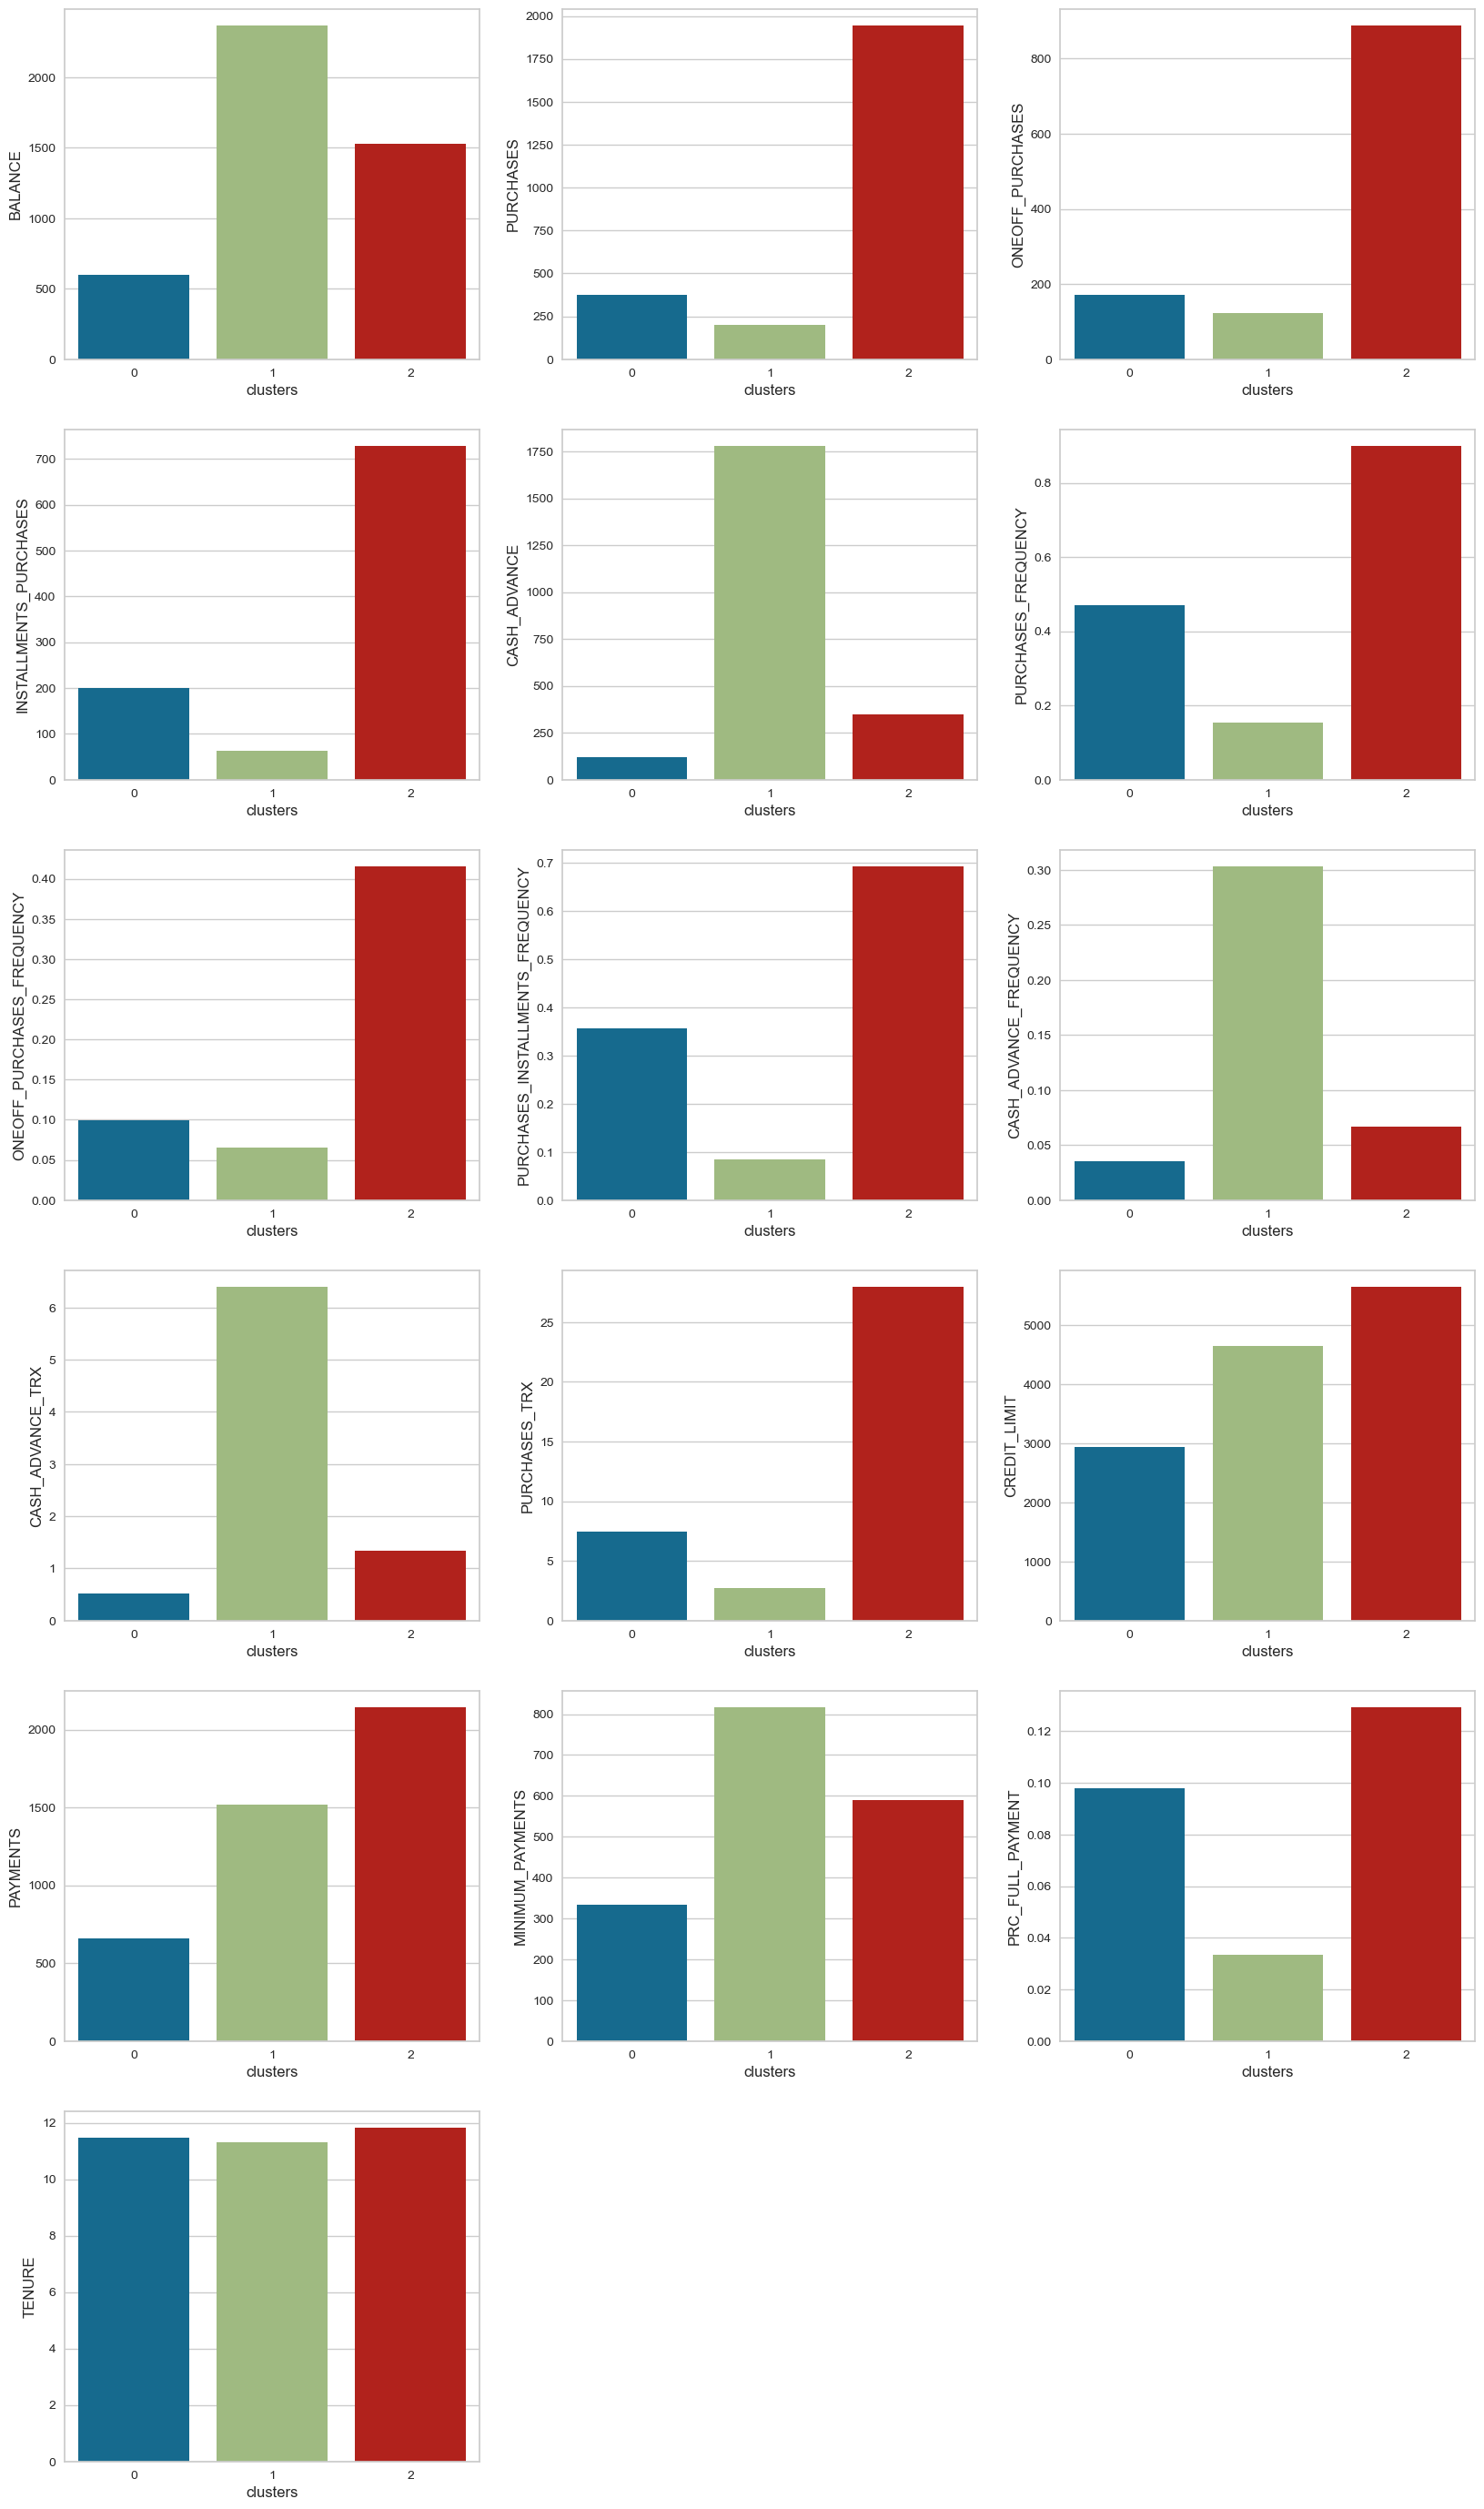

In [46]:
plt.figure(figsize=(20,35))
for i,col in enumerate (df_capped.columns[1:]):
    ax = plt.subplot(6, 3, i+1)
    sns.barplot(data=df_cluster3[1:], x="clusters", y=col,ci=None)

Dari ke-3 cluster hasil PCA-transformed dan K-Means, didapat bahwa karakteristik menurut barplot di atas bahwa masing-masing cluster mengikuti deskripsi berikut :
- cluster 0 : 
> clients yang memiliki balance terendah dengan pembelian dan installment purchases yang tidak terlalu tinggi, limit paling sedikit dan dengan payments paling kecil. Diduga clients yang tidak terlalu membutuhkan cc untuk mengatur cashflow


- cluster 1 :
> clients yang aktif membayar cash in advance meskipun tidak sering menggunakan cc, lebih memilih untuk melakukan cash in advance daripada melakukan installment purchases. Client yang menggunakan credit card bukan untuk membantu cashflow, melainkan menggunakan credit card untuk pengganti pembayaran. Melakukan medium payment dengan limit kredit card urutan menengah.


- cluster 2 :
> clients yang mempunyai medium balance dengan limit tertinggi serta sering melakukan pembelian dan installment purchases. Lebih sering melakukan installment daripada cash in advance dengan transaksi dalam jumlah yang besar. Kemungkinan adalah pebisnis yang menunggu customer dari pebisnis ini untuk membayar pada jatuh tempo, dilihat dari transaksi full paymentnya yang tinggi. Clients yang aktif menggunakan cc demi mendukung bisnis client ini.

Dari ketiga cluster yang didapat, dapat diketahui bahwa promosi yang baik dapat dimaksimalkan kepada clients dari cluster 2 dan 1, sedangkan untuk cluster 0, minat clients tersebut terhadap cc masih rendah. Perlu dilakukan promosi yang berbeda terhadap ketiga cluster ini.
- Cluster 0 akan diberikan promosi seperti pengguna baru yakni dengan penawaran bonus potongan harga dalam pembelian aset/makanan tertentu (barang-barang ringan). Diberikan persentase cashback yang tinggi dengan maksimal nilai cashback yang rendah dan difokuskan ke barang-barang esensial (foor and beverage, personal care, dsb)
- Cluster 1 akan diberikan penawaran seperti asuransi (bukan sesuatu yang bukan pembelian) yang sangat cocok dengan clients cluster ini dimana mereka rajin melakukan cash advance namun tidak sering melakukan pembelian
- Cluster 2 akan diberikan rekomendasi pembelian barang-barang aset atau hal yang berguna bagi bisnis client tersebut (dibutuhkan telemarketing juga) agar client ini dapat menggunakan cc untuk membeli barang penting bagi client pada cluster ini, bisa jg diberikan promosi cashback untuk barang-barang yang sering dibeli oleh clients cluster ini dengan minimum payment yang tinggi

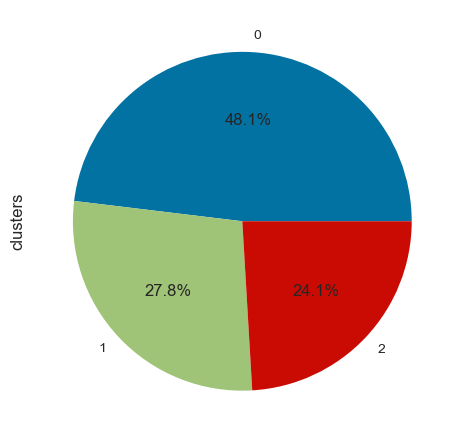

In [48]:
# melihat seberapa banyak persebaran clients menurut ketiga cluster
df_cluster3['clusters'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.show()

Terdapat 48.1% clients yang termasuk cluster 0 (sangat jarang menggunakan credit card), dan 27.8% clients yang menggunakan cc pada payment medium dan 24.1% clients yang menggunakan cc untuk jumlah uang yang sangat besar.

__Kesimpulan Hasil Model Berdasarkan Cluster__ : **`Kelemahan model`** yang didapat adalah masih menggambarkan sedikit imbalance dari hasil persebaran cluster, namun sebetulnya sudah cukup representatif (**`kelebihan model`**). \
Selanjutnya, untuk **`model improvement`**, bisa dilakukan tuning menggunakan parameter lain atau mencoba mengelompokkan cluster dengan jumlah n yang berbeda atau bisa juga menggunakan metode pca yang lain.

## Model Saving

In [177]:
# Save the Files

import pickle
import json

with open('gc4/pca_final_model.pkl', 'wb') as file_1:
    pickle.dump(pca_final, file_1)
    
with open('gc4/km_pca1_model.pkl', 'wb') as file_2:
    pickle.dump(km_pca1, file_2)
    
with open('gc4/pca_2d_model.pkl', 'wb') as file_3:
    pickle.dump(pca_2d, file_3)
    
with open('gc4/numerical_scaler.pkl', 'wb') as file_5:
    pickle.dump(scaler, file_5)

with open('gc4/list_num_cols.txt', 'w') as file_4:
    json.dump(num_cols.tolist(), file_4)
    
with open('gc4/model_imputer.pkl', 'wb') as file_7:
    pickle.dump(imputer, file_7)
    
with open('gc4/model_windsoriser.pkl', 'wb') as file_8:
    pickle.dump(windsoriser, file_8)

In [130]:
# Create random sample to be used in model inference
df_inf=df_ori.sample(n=10)
df_inf.reset_index(drop=True, inplace=True)
df_inf.to_csv('gc4/data_inf.csv')

## Conclusion

- Lebih dari 50% clients memiliki low balance, dengan total pembelian yang jarang dan sedikit serta jarang sekali melakukan cash in advance
- Sebagian besar clients tidak sering melakukan cash in advance, jarang melakukan pembelian dan pembayaran, memiliki limit credit menengah ke bawah, dan melakukan installment daripada cash in advance
- Berdasarkan metode K-Means Clustering, didapat jumlah cluster yang baik untuk mengelompokkan clients adalah n_cluster=3 dengan menggunakan data yang sudah direduksi dimensinya menggunakan PCA
- Dari hasil cluster, didapat 3 kategori customer yakni customer yang jarang menggunakan cc (cluster 0), customer yamg tidak menggunakan cc untuk pembelian (cluster 1), dan customer yang sering melakukan transaksi dan dalam jumlah yang sangat besar (cluster 2)
- Ada 3 jenis rekomendasi untuk promosi ke masing-masing clients, yakni penawaran bonus potongan harga dalam pembelian barang esensial (barang-barang ringan) dengan persentase cashback besar namun bernilai kecil, untuk cluster 0, penawaran cashbak asuransi (cluster 1),  potongan harga untuk pembelian barang-barang aset atau hal yang berguna bagi bisnis client tersebut (cluster 2)
- Kelemahan model yang didapat adalah masih menggambarkan sedikit imbalance dari hasil persebaran cluster, sebaiknya dilakukan tuning menggunakan parameter lain atau mencoba mengelompokkan cluster dengan jumlah n yang berbeda

## Answering the Conceptual Problem

1. Inertia pada algoritma K-Means adalah ukuran jarak total dari setiap titik data ke pusat klaster terdekatnya. Dalam konteks K-Means, inertia sering disebut sebagai Sum of Squared Distances (SSD) atau Within-Cluster Sum of Squares (WCSS). Inertia digunakan untuk mengukur seberapa baik klaster-klaste yang dibuat oleh algoritma K-Means. Tujuannya adalah untuk mencari nilai yang paling optimal untuk jumlah klaster (K) dalam dataset tertentu, sehingga meminimalkan inertia.
2. Elbow Method adalah salah satu teknik yang digunakan dalam analisis klastering (clustering) untuk menentukan jumlah klaster yang optimal, didasarkan pada pengamatan bahwa ketika jumlah klaster meningkat, nilai inersia (inertia) atau variabilitas data dalam klaster tersebut akan semakin kecil. Namun, peningkatan jumlah klaster juga akan menambah kompleksitas model. \
\
 Pada dasarnya, Elbow Method bekerja dengan menghitung inersia (inertia) atau nilai SSE (sum of squared errors) untuk setiap jumlah klaster yang berbeda. Kemudian, grafik nilai inersia versus jumlah klaster digambarkan, dan titik di mana penurunan inersia terlihat melambat (mirip seperti lengkungan pada siku) disebut "elbow". Jumlah klaster pada titik elbow dipilih sebagai jumlah klaster optimal.
\
 Kelebihan dari metode ini adalah mudah dipahami dan diterapkan. Selain itu, Elbow Method dapat membantu dalam memperkirakan jumlah klaster optimal secara visual dan konsisten dengan inersia data.
\
 Namun, kelemahan Elbow Method adalah bahwa pada kasus data yang kompleks dan multi-dimensional, kurva elbow mungkin tidak selalu jelas dan dapat menyebabkan kesulitan dalam menentukan jumlah klaster yang optimal. Selain itu, metode ini bergantung pada inisialisasi acak, yang dapat menghasilkan solusi yang berbeda pada setiap percobaan, sehingga memerlukan pengulangan yang banyak untuk memastikan hasil yang konsisten.